In [2]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import OrderedDict

from numpy.linalg import inv
from scipy import misc

import math

from scipy import interpolate
from scipy import integrate
import matplotlib.cm as cm
import scipy
import scipy.optimize as opt
from scipy.optimize import minimize
from itertools import cycle

import sys
sys.path.insert(0, '/Users/mariavincenzi/PhD/pycoco_2/')
import GP2dim_utils as GP2dim

import sys
sys.path.insert(0, '/Users/mariavincenzi/PhD/pycoco_2/')
import pycoco_general_info as PyCoCo_info

import george
from george.kernels import Matern32Kernel
%matplotlib inline

In [3]:
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/data/"
FILTER_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Sullivan_Filters/"

CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq', 'SN2006aa']
pre_bump = ['SN2011dh','SN1993J','SN2008D','SN2011fu','SN2006aj','SN1987A','SN2013df']

In [4]:
color_dict = {'A':'grey',
              'BessellU': 'blue',
              'BessellB': 'royalblue',
                'BessellV':  'limegreen',
                'BessellR':  'red',
                'BessellI':  'mediumvioletred',
                'SDSS_g':    'darkgreen',
                'SDSS_i':    'purple',
                'SDSS_r':    'darkred',
                'SDSS_z':    'sienna',
                'SDSS_u': 'darkblue',
                'swift_UVW1':'grey',
                'swift_UVW2':'grey',
                'swift_UVM2':'grey',
                'swift_U':'grey',
                'swift_V':'grey',
                'swift_B':'grey'}

color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'mediumvioletred',
                'sdss_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'darkred', "sdss_r'":    'darkred',
                'sdss_z':    'sienna', "sdss_z'":    'sienna',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue'}

convert2mjd = (lambda x: float(x.replace('_REmangled_spec.txt','')\
                               .replace('_REmangled_spec_FL.txt','')\
                               .replace('_mangled_spec.txt','')))

In [5]:
def calc_lam_eff(wls, transmission):
    return (integrate.trapz(transmission*wls, wls)/\
            integrate.trapz(transmission, wls))



In [6]:
class FullMangledSeries_Class():
    """Class to load and mangle a single spectrum:
    """
    
    def __init__(self, main_path, snname, type_=None, spec_file=None, 
                 mode = 'extend_spectra' , verbose=False, DELTA=50.):
        """
        mode: 'extend_spectra'  or 'extrapolate_spectra' 
        """
        ## Initialise the class variables            
        self.main_path = main_path
        self.snname = snname
        self.SNtype = type_
        self.mode = mode
        self.get_mangledspec_list()
        self.DELTA = DELTA
        self.verbose = verbose
        self.create_extended_spec_folder() 
        self.path_fit_phot = self.main_path+'/results_template/%s/fitted_phot_%s.dat'%(snname,snname)
        
    def get_mangledspec_list(self, extend_spectra = True, extrapolate_spectra=False, verbose=False):
        if self.mode == 'extend_spectra':
            mypath = self.main_path+'/results_template/%s/mangled_spectra'%self.snname
            onlyfiles = [f for f in os.listdir(mypath) \
                     if os.path.isfile(os.path.join(mypath, f))&('mangled_spec' in f)&('.txt' in f)]
            self.mangledspec_list = onlyfiles
            self.mangled_file_path = mypath+'/'
        elif self.mode == 'extrapolate_spectra':
            #mypath = self.main_path+'/results_template/%s/RE_mangled_spectra_2dim'%self.snname
            mypath = self.main_path+'/results_template/%s/mangled_spectra'%self.snname
            onlyfiles = [f for f in os.listdir(mypath) \
#                         if os.path.isfile(os.path.join(mypath, f))&('REmangled_spec' in f)&('.txt' in f)&('_FL' not in f)]
                         if os.path.isfile(os.path.join(mypath, f))&('mangled_spec' in f)&('.txt' in f)]
            self.mangledspec_list = onlyfiles
            self.mangled_file_path = mypath+'/'
        return onlyfiles
    
    def load_mangledfile(self, file):
        mangled_spec = np.genfromtxt(self.mangled_file_path+file, dtype=None,\
                                     encoding="utf-8", names=['wls', 'flux', 'fluxerr', 'mang_mask'])
        return mangled_spec

          
    def load_manglingfile(self, mjd):
        #if not hasattr(self, "results_mainpath"):
        #    self.check_mangling_file()
        mangling_file = self.main_path+'/results_template/%s/fitted_phot4mangling_%s.dat'%(self.snname,self.snname)
        if not os.path.isfile(mangling_file):
            raise Exception("I need the file with fitted photometry in order to mangle a spectrum")
        else:
            phot4mangling = pd.read_csv(mangling_file, sep='\t')
            #print (phot4mangling)#self.phot4mangling = 
            specmjd= mjd#float(self.spec_file.replace('mangled_spec_','').replace('.txt',''))
            self.phot4mangling = (phot4mangling[phot4mangling['spec_mjd']==specmjd])
            if len(self.phot4mangling)<1:
                raise Exception(""" ### ERROR: 
I looked in the file with the PHOTOMETRY for MANGLING 
(i.e. fitted_phot4mangling_SNNAME.dat).
I was loading the photometry to mangle/extend the spectrum you are currently loading
in the GRID. I found NO photometry for it... Maybe you should re run GP fit or check your list of spec.""")

            elif len(self.phot4mangling)>1:
                raise Exception(""" ###  TRICKY ERROR: 
I looked in the file with the PHOTOMETRY for MANGLING 
(i.e. fitted_phot4mangling_SNNAME.dat).
I was loading the photometry to mangle/extend the spectrum you are currently loading
in the GRID. I found two spectra at the exact same MJD and this is problem when
I try to build the TIMExWLS grid with this.
Check the phot4mangling.txt file and check if you're MJDs are correct and 
have the right decimals.""")
            self.avail_filters = [col.replace('_fitflux','') for col in phot4mangling.columns\
                                  if col[-8:]=='_fitflux']        
    
    def create_extended_spec_folder(self):
        save_plot_path = self.main_path+'/results_template/%s/TwoDextended_spectra'%snname
        if not os.path.exists(save_plot_path):
            os.makedirs(save_plot_path)
        else:
            os.system('rm -rf %s'%save_plot_path)
            os.makedirs(save_plot_path)

        self.save_plot_path = save_plot_path
        
    def running_mean_std(self, x, y, delta_fix=500.):
        #x = xnan[~np.isnan(ynan)]
        #y = ynan[~np.isnan(ynan)]
        
        total_bins = int((x.max()-x.min())/delta_fix)
        bins = np.linspace(x.min(),x.max(), total_bins)
        try:
            delta = bins[1]-bins[0]
            idx  = np.digitize(x,bins)
            running_median_x = np.array([np.mean(x[idx==k]) for k in np.arange(1,total_bins,1)])
            running_mean = np.array([np.mean(y[idx==k]) for k in np.arange(1,total_bins,1)])
            running_std = np.array([np.std(y[idx==k]) for k in np.arange(1,total_bins,1)])
        except IndexError:
            running_median_x = np.array([np.mean(x)])
            running_mean = np.array([np.mean(y)])
            running_std = np.array([np.std(y)])
            
        clean_running_median_x = np.copy(running_median_x)
        clean_running_median_x[running_mean<0.] = np.nan
        clean_running_mean = np.copy(running_mean)
        clean_running_mean[running_mean<0.] = np.nan
        clean_running_std = np.copy(running_std)
        clean_running_std[running_mean<0.] = np.nan
        
        return clean_running_median_x, clean_running_mean, clean_running_std

    def get_filt_transmission(self, filter_name):
        
        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        wls = filt_transm['wls']
        transmission = filt_transm['flux']
        return wls, transmission

    def lam_eff(self, filter_name):
        wls, transmission = self.get_filt_transmission(filter_name)
        return (integrate.trapz(transmission*wls, wls)/\
            integrate.trapz(transmission, wls))

    def load_phot_for_extention(self, file, anchor = False):
        data_spec_mangled = self.load_mangledfile(file)
        mjd = convert2mjd(file)
        self.load_manglingfile(mjd)
        all_fitted_phot_list=[]
        fitted_phot_list=[]
        fitted_photerr_list=[]
        wls_eff=[]
        filters4extention=[]
        for filt in self.avail_filters:
            lam_eff_value = self.lam_eff(filt)
            fitted_phot = self.phot4mangling['%s_fitflux'%filt].values
            fitted_phot_err = self.phot4mangling['%s_fitfluxerr'%filt].values
            all_fitted_phot_list.append(fitted_phot[0])
            inrange = self.phot4mangling['%s_inrange'%filt].values
            #if (lam_eff_value>max(data_spec_mangled['wls'])+200)|(lam_eff_value<min(data_spec_mangled['wls']-200)):
            if (lam_eff_value>max(data_spec_mangled['wls']))|(lam_eff_value<min(data_spec_mangled['wls'])):
                if inrange:
                    if self.verbose: print (filt, lam_eff_value, fitted_phot, mjd)
                    fitted_phot_list.append(fitted_phot[0])
                    fitted_photerr_list.append(fitted_phot_err[0])
                    wls_eff.append(lam_eff_value)
                    filters4extention.append(filt)

        fitted_phot_list=np.array(fitted_phot_list)[np.argsort(wls_eff)]
        fitted_photerr_list = np.array(fitted_photerr_list)[np.argsort(wls_eff)]
        filters4extention=np.array(filters4extention)[np.argsort(wls_eff)]
        wls_eff = np.sort(wls_eff)

        self.phot4extention = {'mjd':mjd,'wls_eff':wls_eff,\
                                 'phot':fitted_phot_list,\
                                 'phot_err':fitted_photerr_list,
                              'names':filters4extention}
        return (self.phot4extention)
    
    def grid_all_spectraltimeseries(self):
        ungrid_data_wls= []
        ungrid_data_flux= []
        ungrid_data_fluxerr= []
        mjd =[]
        
        DELTA= self.DELTA#70.
        for f in self.mangledspec_list:
            spec = self.load_mangledfile(f)
            if self.verbose: print (f, len(spec))
            #smoothed_wls, smoothed_flux, smoothed_flux_err = \
            #        self.running_mean_std(spec['wls'], spec['flux'], delta_fix=DELTA)
            
            smoothed_wls = spec['wls'][~np.isnan(spec['flux'])]
            smoothed_flux = spec['flux'][~np.isnan(spec['flux'])]
            smoothed_flux_err = spec['fluxerr'][~np.isnan(spec['flux'])]
            
            ungrid_data_wls.append(smoothed_wls)
            ungrid_data_flux.append(smoothed_flux)
            ungrid_data_fluxerr.append(smoothed_flux_err)
            mjd.append(convert2mjd(f))
        grid_wls = np.arange(1590., 11050., DELTA)
        grid_mjd = np.array(mjd)
        grid_all = pd.DataFrame()
        grid_all_err = pd.DataFrame()
        
        fig = plt.figure(figsize=(11,4))#(15,11))

        for ii in range(len(ungrid_data_flux)):
            grid_flux = np.ones(len(grid_wls))
            grid_fluxerr = np.ones(len(grid_wls))

            minwls = np.min(ungrid_data_wls[ii][~np.isnan(ungrid_data_wls[ii])])
            maxwls = np.max(ungrid_data_wls[ii][~np.isnan(ungrid_data_wls[ii])])
            data_mask = (grid_wls>=minwls)&(grid_wls<=maxwls)
            flux_interp = np.interp(grid_wls[data_mask], ungrid_data_wls[ii], ungrid_data_flux[ii])
            flux_interp_err = np.interp(grid_wls[data_mask], ungrid_data_wls[ii], ungrid_data_fluxerr[ii])
            plt.plot(ungrid_data_wls[ii], ungrid_data_flux[ii], lw=0.5, color='k')#, label='unsmoothed spectra')
            plt.plot(grid_wls[data_mask], flux_interp, '.r', ms=3)#, label='points in grid')
            plt.fill_between(grid_wls[data_mask], flux_interp-flux_interp_err, \
                                 flux_interp+flux_interp_err, alpha=0.2, color='r')
            grid_flux[data_mask] = flux_interp
            grid_flux[~data_mask] = np.nan
            grid_fluxerr[data_mask] = flux_interp_err
            grid_fluxerr[~data_mask] = np.nan
            grid_all[str(grid_mjd[ii])]=grid_flux
            grid_all_err[str(grid_mjd[ii])]=grid_fluxerr
        plt.title(self.snname+' Red: rebbined spectra for grid, Black: original unsmoothed spec')
        plt.show()
        plt.close(fig)
        grid_all = grid_all.set_index(grid_wls)
        grid_all.columns = grid_mjd
        grid_all_err = grid_all_err.set_index(grid_wls)
        grid_all_err.columns = grid_mjd
        self.grids = [grid_wls, grid_mjd, grid_all, grid_all_err]
        
        return grid_wls, grid_mjd, grid_all, grid_all_err

    
    def band_flux_modified(self, filter_name, file):
        
        spec_flux = self.load_mangledfile(file)
        
        
        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif self.snname in CSP_SNe:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        
        lam_eff = calc_lam_eff(filt_transm['wls'], filt_transm['flux']) 
        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], filt_transm['flux'], kind='linear')
        cut_spec = [(spec_flux['wls']>min(filt_transm['wls']))&\
                     (spec_flux['wls']<max(filt_transm['wls']))]
        cut_ext_spec = spec_flux[cut_spec]
        filt_transm_interp = filt_transm_interp_func(cut_ext_spec['wls'])
        #
        raw_phot = integrate.trapz(filt_transm_interp*cut_ext_spec['flux'], cut_ext_spec['wls'])/\
                 integrate.trapz(filt_transm['flux'], filt_transm['wls'])
        return lam_eff, raw_phot
                
        
    def extend_grid_all_spectraltimeseries(self):
        if not hasattr(self, 'grids'):
            self.grid_all_spectraltimeseries()
        
        grid_notext = (self.grids[2]).copy()
        grid_notext_err = (self.grids[3]).copy()

        for f in self.get_mangledspec_list():
            self.load_phot_for_extention(f)
            phot4ext = self.phot4extention
            for ind in range(len(phot4ext['wls_eff'])):#np.where(phot4ext['wls_eff']<3500.)[0]:
                #if th raw associated with the wls doesnt exist create it
                phot_cut = self.band_flux_modified(phot4ext['names'][ind], f)[1]
                UVwls = phot4ext['wls_eff'][ind]
                if phot4ext['names'][ind] in ['swift_UVW1', 'swift_UVW2', 'swift_UVM2']:
                    phot_perc = (100.*phot_cut/(phot4ext['phot'][ind]))
                else: phot_perc = 0.
                if self.verbose: print ('UV synth versus obs phot %.2f'%phot_perc)
                if self.verbose: print ('UV synth - obs phot %.2E'%(phot4ext['phot'][ind]-phot_cut))
                if UVwls not in grid_notext.index:
                    grid_notext.loc[UVwls]= np.nan*np.ones(grid_notext.shape[1])
                    grid_notext_err.loc[UVwls]= np.nan*np.ones(grid_notext_err.shape[1])
                if (phot_perc>1)&(phot_perc<99):
                    grid_notext.loc[UVwls][phot4ext['mjd']] = phot4ext['phot'][ind]-phot_cut
                else: grid_notext.loc[UVwls][phot4ext['mjd']] = phot4ext['phot'][ind]
                grid_notext_err.loc[UVwls][phot4ext['mjd']] = phot4ext['phot_err'][ind]

        LC_fit = self.open_LCfit_file()
        filters_LC = [i for i in LC_fit.columns[1:] if '_err' not in i]
        mjds_LC = LC_fit['MJD'].values
        min_mjds_LC =[]
        max_mjds_LC =[]
        for band in filters_LC:
            mjd_filt = mjds_LC[~np.isnan(LC_fit[band].values)]
            min_mjds_LC.append(min(mjd_filt))
            max_mjds_LC.append(max(mjd_filt))
            if self.lam_eff(band) not in grid_notext.index:
                grid_notext.loc[self.lam_eff(band)] = np.full(len(grid_notext.columns), np.nan)
                grid_notext_err.loc[self.lam_eff(band)] = np.full(len(grid_notext.columns), np.nan)

        if self.mode=='extrapolate_spectra':
            def fill_gaps(min_mjd_phot, max_mjd_phot, spec_mjd, gap_size=2., fill_cadence=2.):
                f = np.concatenate(([min_mjd_phot], spec_mjd, [max_mjd_phot]))
                gaps_mjd = f - np.concatenate(([min_mjd_phot], f[:-1]))
                extention=[]
                for gap,offset in zip(gaps_mjd[gaps_mjd>gap_size], f[gaps_mjd>gap_size]):
                    step = (gap/round(gap/fill_cadence,0))
                    N = int(round(gap/fill_cadence,0))
                    for i in range(N-1):
                        extention.append(offset - (i+1)*step)
                return extention
            
            if (self.snname in pre_bump):
                early_extrap = np.linspace(min(min_mjds_LC),min(min_mjds_LC)+5., 15)
                mjds_extention = np.sort(np.concatenate([early_extrap,
                            fill_gaps(min(min_mjds_LC), max(max_mjds_LC), 
                                               grid_notext.columns)]))
            else:
                early_extrap = np.linspace(min(min_mjds_LC),min(min_mjds_LC)+5., 7)
                mjds_extention = np.sort(np.concatenate([early_extrap,
                            fill_gaps(min(min_mjds_LC), max(max_mjds_LC), 
                                               grid_notext.columns)]))
            
            if (max(mjds_extention-min(mjds_extention))>200.):
                mjds_extention = mjds_extention[(mjds_extention-min(mjds_extention))<200.]
                if self.verbose:
                    print ('Max phase roughly %.2f.'%max((mjds_extention-min(mjds_extention))))
                    print ('Chopping this to 200 days after first detection')
            mjds_grid = np.sort(np.concatenate([mjds_extention,grid_notext.columns]))
                   
            for m in range(len(mjds_extention)):
                if mjds_extention[m] not in grid_notext.columns:
                    grid_notext[mjds_extention[m]] = np.full(len(grid_notext.index), np.nan)
                    grid_notext_err[mjds_extention[m]] = np.full(len(grid_notext_err.index), np.nan)
            #grid_notext.columns = mjds_grid
            for band in filters_LC:
                no_nan = [(~np.isnan(LC_fit[band].values))&(~np.isnan(LC_fit[band+'_err'].values))]
                mjd_filt = mjds_LC[no_nan]
                flux_filt = (LC_fit[band].values)[no_nan]
                fluxerr_filt = (LC_fit[band+'_err'].values)[no_nan]
                mask_grid = (mjds_grid>min(mjd_filt))&(mjds_grid<max(mjd_filt))
                LC_val = np.full(len(mjds_grid), np.nan)
                LC_val[mask_grid] = np.interp(mjds_grid[mask_grid], mjd_filt, flux_filt)
                LCerr_val = np.full(len(mjds_grid), np.nan)
                LCerr_val[mask_grid] = np.interp(mjds_grid[mask_grid], mjd_filt, fluxerr_filt)
                for m in range(len(mjds_grid)):
                    if (mjds_grid[m] in mjds_extention)&(m % 3 == 0 ):
                        grid_notext[mjds_grid[m]].loc[self.lam_eff(band)] = LC_val[m]
                        grid_notext_err[mjds_grid[m]].loc[self.lam_eff(band)] = LCerr_val[m]
            
        grid_ext = grid_notext.sort_index(inplace=False)
        grid_ext_err = grid_notext_err.sort_index(inplace=False)

        grid_ext_full = grid_ext.sort_index(axis=1, inplace=False)
        grid_ext_err_full = grid_ext_err.sort_index(axis=1, inplace=False)
        self.extended_grid = grid_ext_full
        return grid_ext_full.index, grid_ext_full.columns, grid_ext_full, grid_ext_err_full

    def get_filter_LC(self):
        LC_fit = self.open_LCfit_file()
        filters_LC = [i for i in LC_fit.columns[1:] if '_err' not in i]
        self.avail_filters = filters_LC
        return filters_LC
        
    def open_LCfit_file(self):
        #if not hasattr(self, "results_mainpath"):
        #    self.check_mangling_file()
        LC_file = self.main_path+'/results_template/%s/fitted_phot_%s.dat'%(self.snname,self.snname)
        if not os.path.isfile(LC_file):
            print ("I need the file with fitted photometry in order to mangle a spectrum")
        else:
            fittphot = pd.read_csv(LC_file, sep='\t')
        return fittphot
    
    def get_spec_mjd(self):
        return np.array([convert2mjd(f) for f in self.get_mangledspec_list()])
    

In [7]:
sn_type_lista = [('ASASSN14jb', 'II'),
 ('ASASSN15oz', 'II'),
 ('SN1993J', 'IIb'),
 ('SN1994I', 'Ic'),
 ('SN1998bw', 'Ic-BL'),
 ('SN1999dn', 'Ib'),
 ('SN1999em', 'II'),
 ('SN2002ap', 'Ic-BL'),
 ('SN2004aw', 'Ic'),
 ('SN2004et', 'II'),
 ('SN2004fe', 'Ic'),
 ('SN2004gq', 'Ib'),
 ('SN2004gt', 'Ic'),
 ('SN2004gv', 'Ib'),
 ('SN2005bf', 'Ib'),
 ('SN2005cs', 'II'),
 ('SN2005hg', 'Ib'),
 ('SN2006T', 'IIb'),
 ('SN2006aa', 'IIn'),
 ('SN2006aj', 'Ic-BL'),
 ('SN2006ep', 'Ib'),
 ('SN2007Y', 'Ib'),
 ('SN2007gr', 'Ic'),
 ('SN2007od', 'II'),
 ('SN2007pk', 'IIn'),
 ('SN2007ru', 'Ic-BL'),
 ('SN2007uy', 'Ib'),
 ('SN2008D', 'Ib'),
 ('SN2008aq', 'IIb'),
 ('SN2008ax', 'IIb'),
 ('SN2008bj', 'II'),
 ('SN2008bo', 'IIb'),
 ('SN2008fq', 'IIn'),
 ('SN2008in', 'II'),
 ('SN2009N', 'II'),
 ('SN2009bb', 'Ic-BL'),
 ('SN2009bw', 'II'),
 ('SN2009dd', 'II'),
 ('SN2009ib', 'II'),
 ('SN2009ip', 'IIn'),
 ('SN2009iz', 'Ib'),
 ('SN2009jf', 'Ib'),
 ('SN2009kr', 'II'),
 ('SN2010al', 'IIn'),
 ('SN2011bm', 'Ic'),
 ('SN2011dh', 'IIb'),
 ('SN2011ei', 'IIb'),
 ('SN2011fu', 'IIb'),
 ('SN2011hs', 'IIb'),
 ('SN2011ht', 'IIn'),
 ('SN2012A', 'II'),
 ('SN2012ap', 'Ic-BL'),
 ('SN2012au', 'Ib'),
 ('SN2012aw', 'II'),
 ('SN2013ab', 'II'),
 ('SN2013am', 'II'),
 ('SN2013by', 'II'),
 ('SN2013df', 'IIb'),
 ('SN2013ej', 'II'),
 ('SN2013fs', 'II'),
 ('SN2013ge', 'Ic'),
 ('SN2014G', 'II'),
 ('SN2016X', 'II'),
 ('SN2016bkv', 'II'),
 ('SN2016gkg', 'IIb'),
 ('iPTF13bvn', 'Ib'),
 ('SN2013bynouv', 'II')]

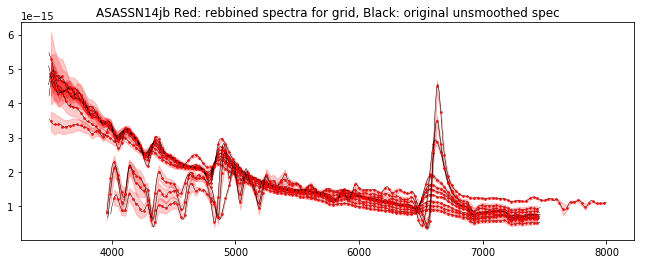

/Users/mariavincenzi/PhD/pycoco_2/GP2dim_utils.py:48: RuntimeWarning: invalid value encountered in less_equal
  data[data_lin<=0.] = np.nan
/Users/mariavincenzi/PhD/pycoco_2/GP2dim_utils.py:56: RuntimeWarning: invalid value encountered in less_equal
  data_err[data_lin<=0.] = np.nan


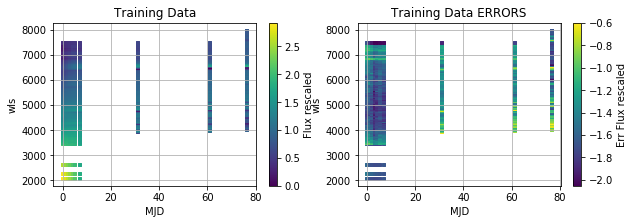

KeyboardInterrupt: 

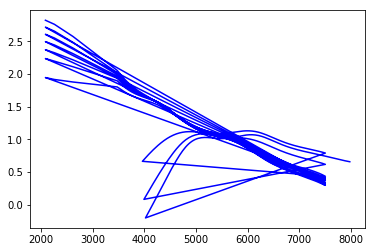

In [8]:
kernel_wls_scale = 0.01
kernel_time_scale = 0.4

for snname,type_ in sn_type_lista[:1]:
    spec_class = FullMangledSeries_Class(main_path=DATALC_PATH, snname=snname, 
                                         mode='extend_spectra',DELTA=30., verbose=False)
    raw_numbers, raw_numbers_err, off_xa, off_ya , grid_ext_columns = GP2dim.prepare_grid(snname, spec_class, )
    y_data_nonan, y_data_nonan_err, x1_data_norm,\
    x2_data_norm = GP2dim.transform2LOG_reshape(spec_class, raw_numbers, raw_numbers_err, off_xa, off_ya)
    GP2dim.make_plots(spec_class, y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm)
    
    Xprior, yprior = GP2dim.setPRIOR(spec_class, type_)
    
    x1_fill, x2_fill, mu_fill, std_fill = GP2dim.run_2DGP_GRID(spec_class, y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm,\
    		 kernel_wls_scale, kernel_time_scale, grid_ext_columns, 
             prior=True, points=Xprior, values=yprior)
    
    GP2dim.make_results_plots(spec_class, x1_fill, x2_fill, mu_fill, std_fill)
    mu_fill_conv, std_fill_conv, y_data_conv = GP2dim.transform_back_andPlot(spec_class, x1_fill, x2_fill, 
                                                                             mu_fill, std_fill, y_data_nonan)
    GP2dim.save_plots_files(spec_class, grid_ext_columns, y_data_conv, x1_fill, x2_fill, 
                            mu_fill_conv, std_fill_conv)

In [9]:
norm1 = spec_class.grid_norm_info['norm1']
norm2 = spec_class.grid_norm_info['norm2']
offset = spec_class.grid_norm_info['offset']
offset2 = spec_class.grid_norm_info['offset2']
scale_factor = spec_class.grid_norm_info['scale_factor']



In [10]:
kernel_wls_scale*norm1, kernel_time_scale*norm2

(110.0, 30.560000000000585)

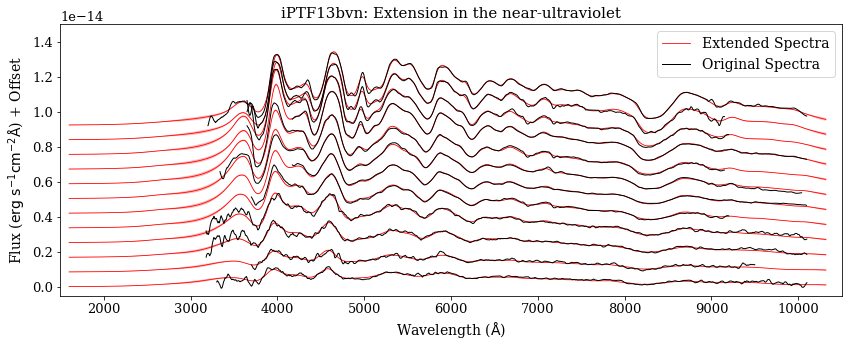

In [12]:
#mpl.rcParams['mathtext.fontset']='stixsans'

norm1 = spec_class.grid_norm_info['norm1']
norm2 = spec_class.grid_norm_info['norm2']
offset = spec_class.grid_norm_info['offset']
offset2 = spec_class.grid_norm_info['offset2']
scale_factor = spec_class.grid_norm_info['scale_factor']

#if LOG:
mu_fill_conv = np.exp(mu_fill*scale_factor + offset)
std_fill_conv = np.abs( scale_factor*mu_fill_conv *std_fill )

y_data_conv = np.exp(y_data_nonan*scale_factor + offset)

fig = plt.figure(1, figsize=(14,5))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)

max_val = np.max(y_data_conv)
med_val = np.median(y_data_conv)

spec_mjd_list = spec_class.get_spec_mjd()[3:15]
scale = (max_val-med_val)/5.
a=0
for j in range(len(spec_mjd_list)):
    mj = spec_mjd_list[j]
    a +=1
    mask = x2_fill==(mj-offset2)/norm2
    plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask]+(a-1)*scale, 
             label='Extended Spectra', lw=0.8, color='r')
    plt.fill_between(x1_fill[mask]*norm1, (mu_fill_conv[mask]-std_fill_conv[mask])+(a-1)*scale , 
                 (mu_fill_conv[mask]+std_fill_conv[mask])+(a-1)*scale , facecolor='r', alpha=0.3)
a=0
mangled_original_list = spec_class.mangledspec_list[3:15]
for j in range(len(spec_mjd_list)):
    mj = spec_mjd_list[j]
    spec_file_original = spec_class.load_mangledfile(mangled_original_list[j])
    a +=1
    mask = x2_fill==(mj-offset2)/norm2
    #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask], label='%i'%(mj-offset2), lw=0.8, color='r')
    #plt.plot(off_xa, grid_ext[mj]+(a-1)*scale, label='Raw spec %i'%(mj-offset2), lw=1.8, color='k')
    plt.plot(spec_file_original['wls'], spec_file_original['flux']+(a-1)*scale,
                     label='Original Spectra', lw=1, color='k')

plt.xlim(1500,10500)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=14)
plt.ylim(-5*10**-16,1.5*10**-14)
#for b in spec_class.avail_filters:
#	wls, T = spec_class.get_filt_transmission(b)
#	plt.plot(wls, 0.5*T*max_val/max(T), linestyle='-', lw=4, color=PyCoCo_info.color_dict[b])
plt.title(spec_class.snname+': Extension in the near-ultraviolet', fontsize=15)
plt.xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=14)
plt.ylabel(r'Flux ($\mathrm{erg}$ $\mathrm{s^{-1} cm^{-2}} \mathrm{\AA} $) + Offset', fontsize=14)
fig.savefig(spec_class.save_plot_path+'/paper_extended_spec.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

In [13]:
y_data_nonan_unscaled = np.exp(y_data_nonan*scale_factor + offset)
y_data_nonan_unscaled_forplot = y_data_nonan_unscaled
x2_forplot = spec_class.grid_norm_info['norm2']*x2_data_norm
x1_forplot = spec_class.grid_norm_info['norm1']*x1_data_norm

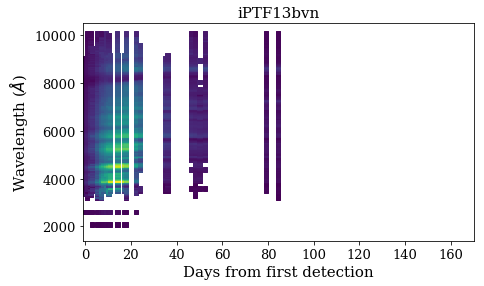

In [14]:

mycmap = plt.cm.viridis
mycmap.set_under('r')

fig = plt.figure(1, figsize=(7,4))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)


plt.scatter(x2_forplot, 
	x1_forplot, marker='s', s=18, c=y_data_nonan_unscaled_forplot)
           #vmin=10**-19, vmax=4.4*10**-15)
#plt.colorbar(label='Flux rescaled')

#cb = plt.colorbar()
#cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=13)
#cb.ax.set_ylabel('Scaled Flux', fontsize=15)

#plt.savefig('gaussian_processes_2d_training_data.png', bbox_inches='tight')
#plt.subplot(122)
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='s', s=10,  c=std_fill_conv, alpha=1., 
#			vmin=0., cmap = mycmap)
##plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
##plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
#plt.xlabel('MJD')
#plt.ylabel('wls')
plt.ylim(1400, 10500)
plt.xlim(-1, 170)
plt.ylabel(r'Wavelength ($\AA$)', fontsize=15)
plt.xlabel(r'Days from first detection', fontsize=15)
#plt.title(spec_class.snname, fontsize=15)
#plt.grid()
plt.title('iPTF13bvn', fontsize=15)
plt.show()
fig.savefig(spec_class.save_plot_path+'/2d_surface_original.png', bbox_inches='tight')
plt.close(fig)

In [15]:
#plt.plot(off_xa, raw_numbers[:,10], '.-')

SN_lista_II = ['SN2013by','SN2014G','ASASSN15oz','SN2007od','SN2013ej','SN2013fs','SN2008bj',
'SN2016X','SN2013ab','SN2009bw','SN2012aw','SN2008in','SN2004et','SN2009dd',
'SN1999em','SN2009kr','ASASSN14jb','SN2012A','SN2009ib','SN2013am','SN2016bkv','SN2009N',
'SN2005cs', 'SN2008fq', 'SN2007pk', 'SN2010al', 'SN2009ip', 'SN2006aa', 
               'SN2011ht','SN2013bynouv']

SN_lista_Ib = ['SN1993J', 'SN2006T', 'SN2008aq', 'SN2008ax', 'SN2008bo', 'SN2011dh', 
               'SN2011ei', 'SN2011fu', 'SN2011hs', 'SN2013df','SN2016gkg', 
               'SN1999dn', 'SN2004gq', 'SN2004gv', 'SN2005bf',
               'SN2005hg', 'SN2006ep',  'SN2007Y', 'SN2007uy',  'SN2008D', 'SN2009iz',
               'SN2009jf', 'SN2012au','iPTF13bvn', 'SN1994I','SN2004aw','SN2004fe',
               'SN2004gt','SN2007gr','SN2011bm','SN2013ge','SN1998bw','SN2002ap','SN2006aj',
               'SN2007ru','SN2009bb', 'SN2012ap']

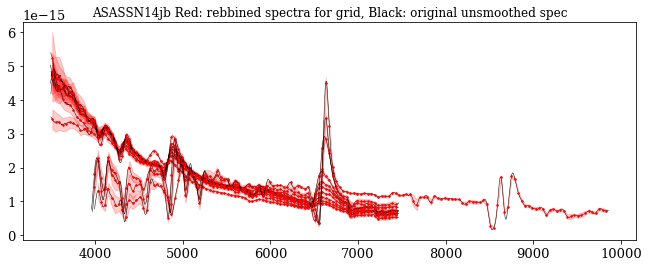

/Users/mariavincenzi/PhD/pycoco_2/GP2dim_utils.py:48: RuntimeWarning: invalid value encountered in less_equal
  data[data_lin<=0.] = np.nan
/Users/mariavincenzi/PhD/pycoco_2/GP2dim_utils.py:56: RuntimeWarning: invalid value encountered in less_equal
  data_err[data_lin<=0.] = np.nan


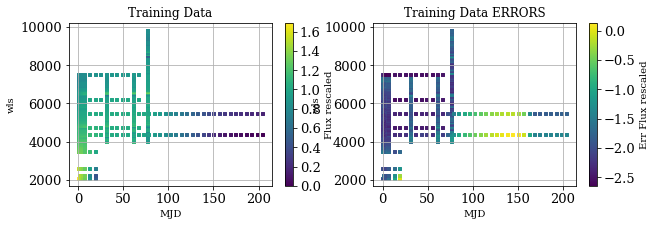

In [31]:
kernel_wls_scale = 0.01
kernel_time_scale = 0.5#0.5

rerun = ['ASASSN14jb']

for snname in rerun:
        spec_class = FullMangledSeries_Class(main_path=DATALC_PATH, snname=snname, 
                                             mode='extrapolate_spectra', DELTA=40., 
                                             verbose=False)
        raw_numbers, raw_numbers_err,\
        off_xa, off_ya , grid_ext_columns = GP2dim.prepare_grid(snname, spec_class)
        y_data_nonan, y_data_nonan_err, x1_data_norm,\
        x2_data_norm = GP2dim.transform2LOG_reshape(spec_class, raw_numbers, raw_numbers_err, off_xa, off_ya)
        GP2dim.make_plots(spec_class, y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm)
        #x1_fill, x2_fill, mu_fill, std_fill = GP2dim.run_2DGP_GRID(spec_class, y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm,\
        #    kernel_wls_scale, kernel_time_scale, grid_ext_columns[::])
    #
    #    GP2dim.make_results_plots(spec_class, x1_fill, x2_fill, mu_fill, std_fill)
    #    mu_fill_conv, std_fill_conv, y_data_conv = GP2dim.transform_back_andPlot(spec_class, x1_fill, x2_fill, 
    #                                                                         mu_fill, std_fill, y_data_nonan)
    #    GP2dim.save_plots_files(spec_class, grid_ext_columns[::], y_data_conv, x1_fill, x2_fill, 
    #                        mu_fill_conv, std_fill_conv)


In [8]:
SN_lista= ['SN2013df', 'iPTF13bvn', 'SN1987A', 'SN1999em', 'SN2004fe',
          'SN1994I','SN1999dn','SN2004gq','SN2004gt','SN2004gv','SN2005bf',
        'SN2005cs', 'SN2005hg', 'SN2006aj', 'Sn2006ep', 'SN1994I',
          'SN2006T','SN2007gr','SN2007od', 'SN2004aw', 'SN2007ru', 'SN2007Y']
SN_lista = ['SN2008aq', 'SN2008in', 'SN2008bj', 'SN2008D', 'SN2009bw',
          'SN2009dd', 'SN2011dh', 'SN2011ei','SN2013ge', 'SN2011ht',
          'SN2011fu', 'SN2011hs', 'SN2012A', 'SN2012au', 'SN2012aw',
          'SN2013by', 'SN2013fs', 'SN2014G', 'SN2016gkg','SN2016X', 'SN2008ax', 
           'SN2008fq', 'SN2009bb', 'SN2009ib', 'SN2009jf', 'SN2009kr', 'SN2013am', 'SN2013ab', 'SN2013df']

SN_lista = ['SN2012aw','SN2007gr','ASASSN14bj', 'ASASSN15oz',
          'SN2013by', 'SN2012A', 'SN2008bj', 'SN2016bkv','SN2007Y']
SN_lista = ['SN2006aj', 'SN2013fs', 'SN2004gv']
#['SN2009bb', 'SN2009iz', 'SN2011dh','SN2011ei','SN2011hs','SN2012au','SN2013df','SN2013ge']

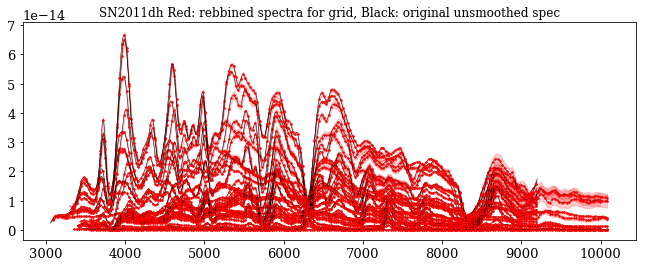

/Users/mariavincenzi/PhD/pycoco_2/GP2dim_utils.py:48: RuntimeWarning: invalid value encountered in less_equal
  data[data_lin<=0.] = np.nan
/Users/mariavincenzi/PhD/pycoco_2/GP2dim_utils.py:56: RuntimeWarning: invalid value encountered in less_equal
  data_err[data_lin<=0.] = np.nan


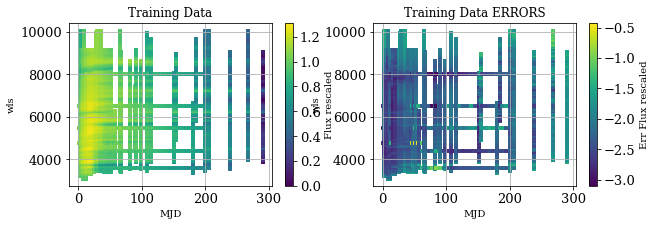

SN2011dh 55712.55000000006


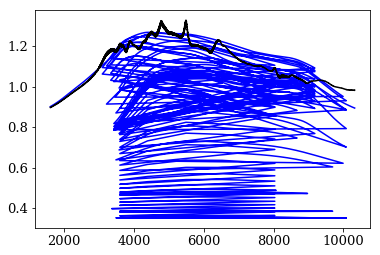

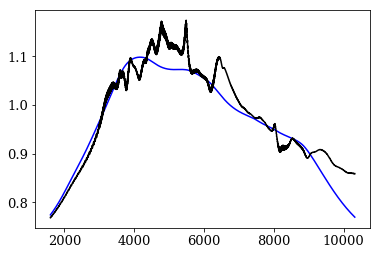

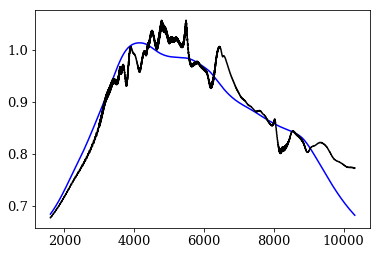

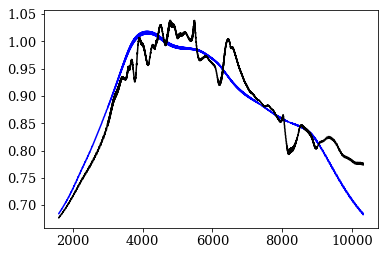

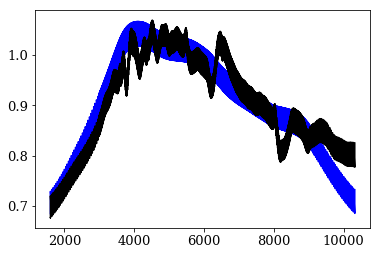

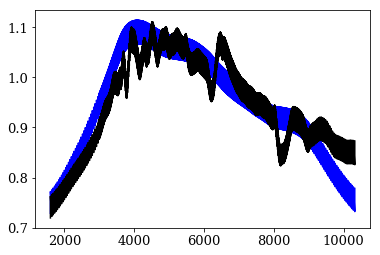

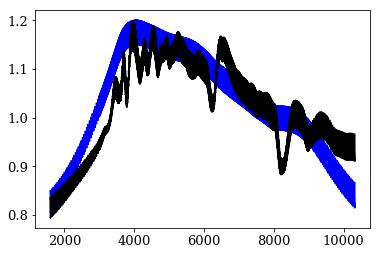

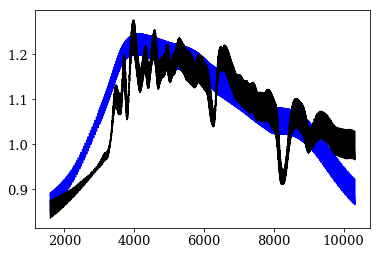

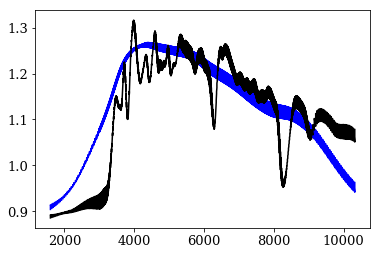

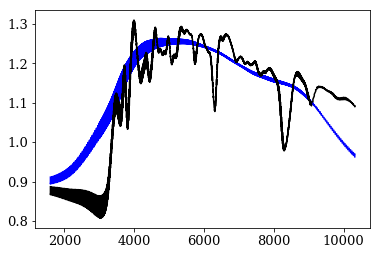

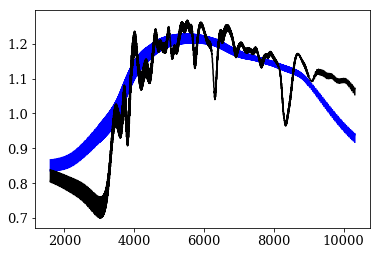

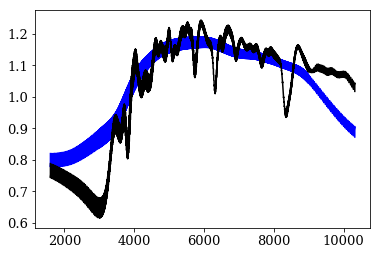

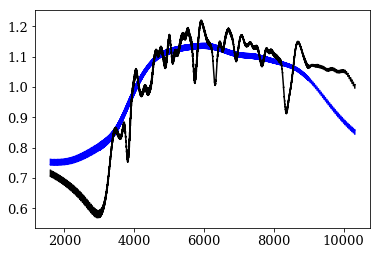

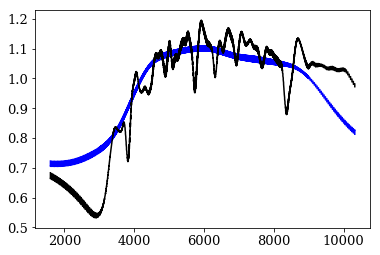

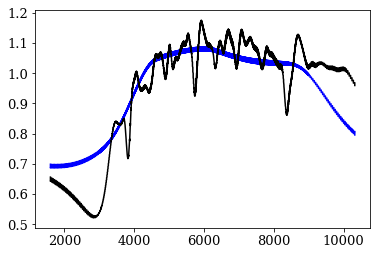

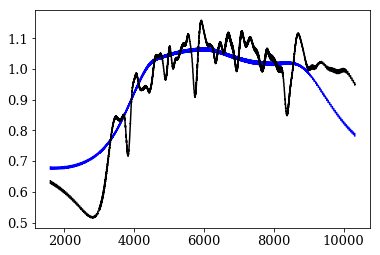

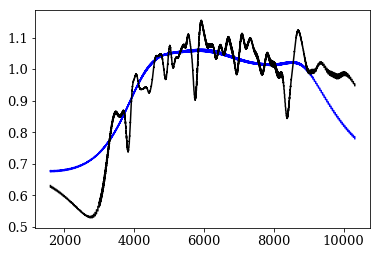

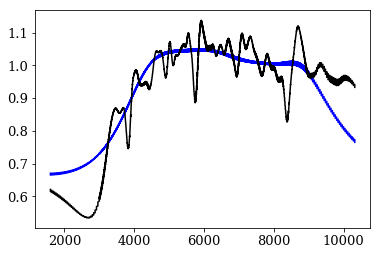

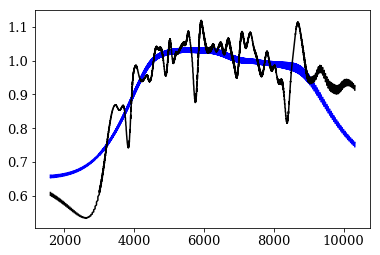

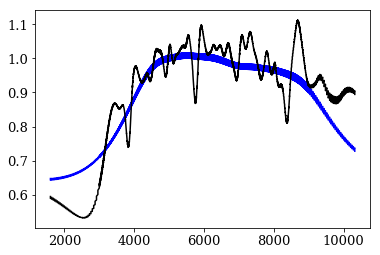

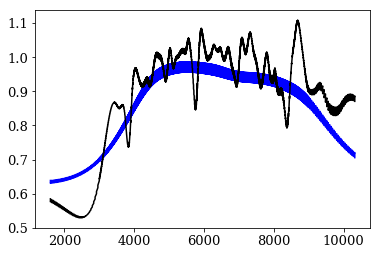

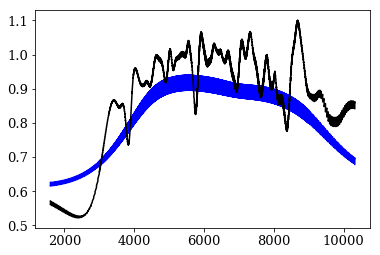

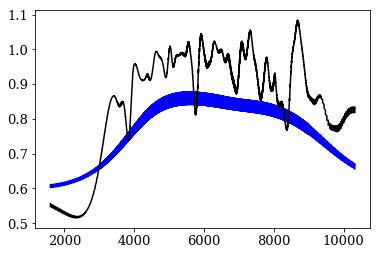

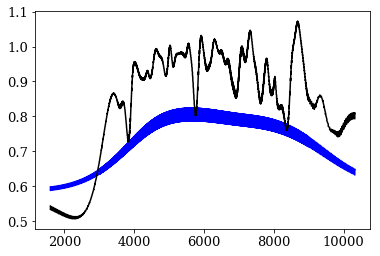

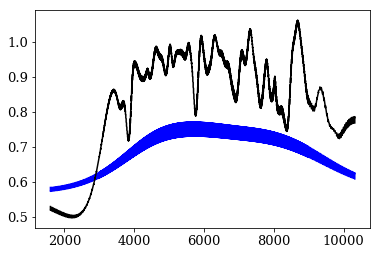

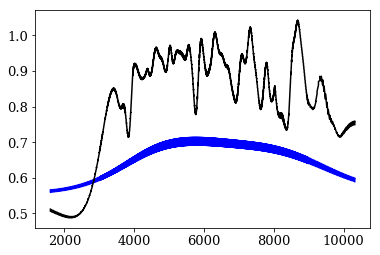

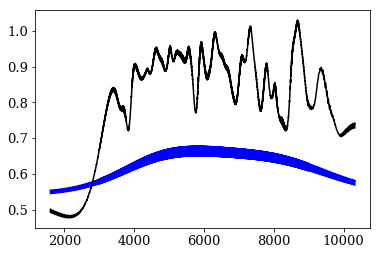

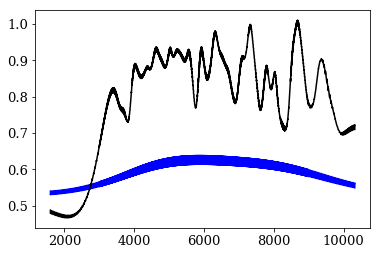

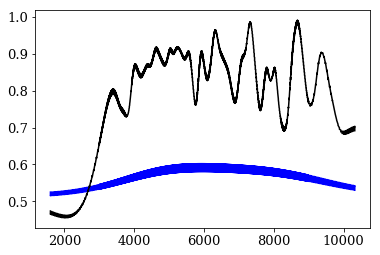

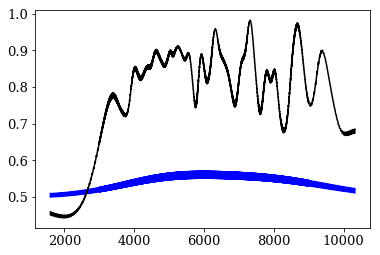

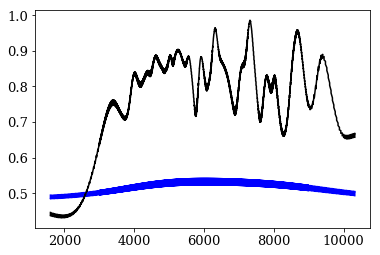

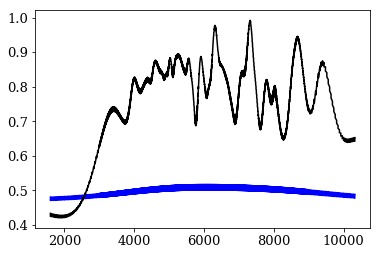

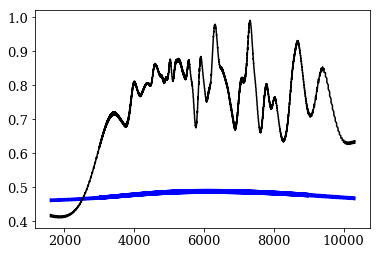

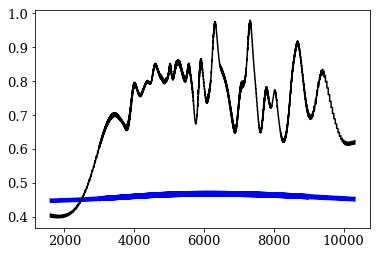

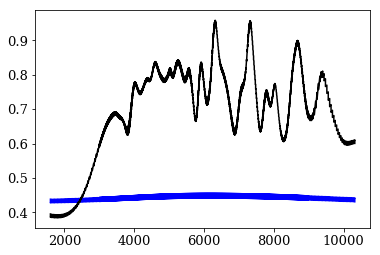

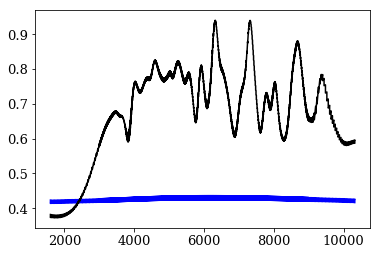

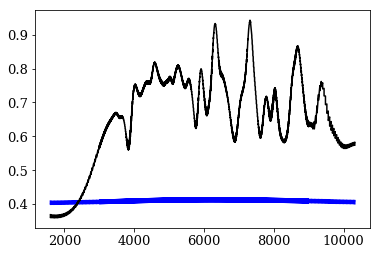

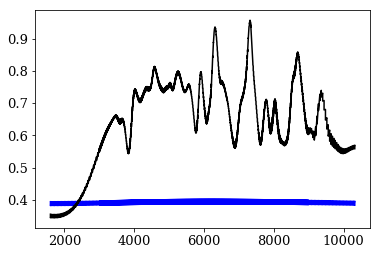

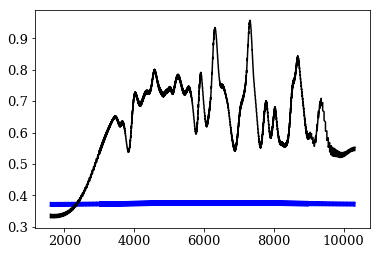

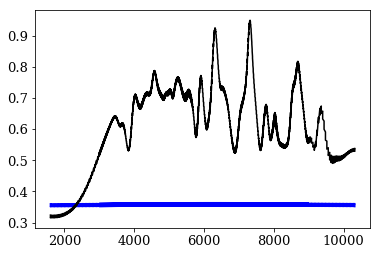

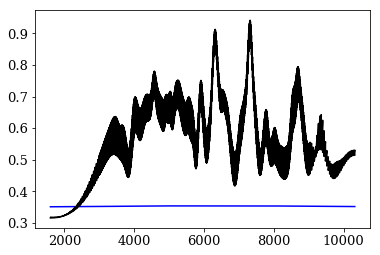

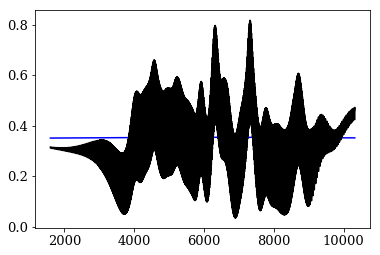

[ ********************  ]126 of 126spec extrapolated
EXTENDING SPECTRA BETWEEN:
WLS: 1600.0 10320.0
MJD: -1.071428571427532 290.37857142851135


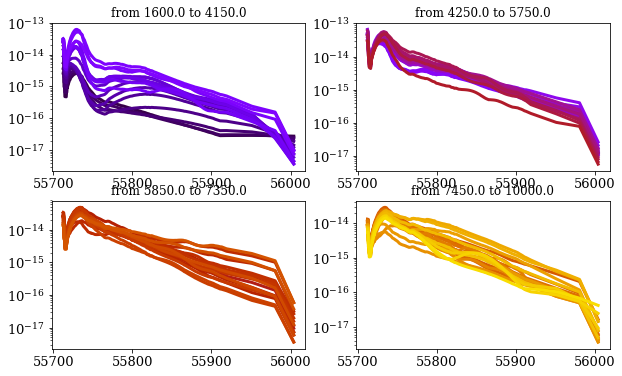

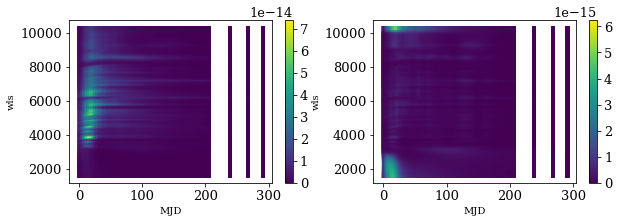

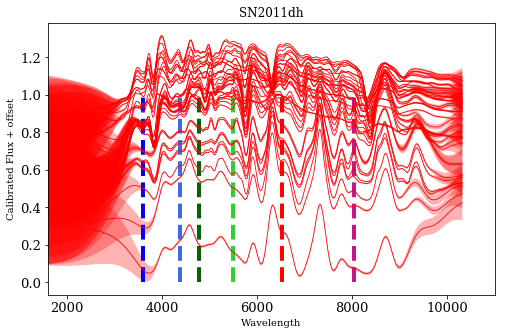

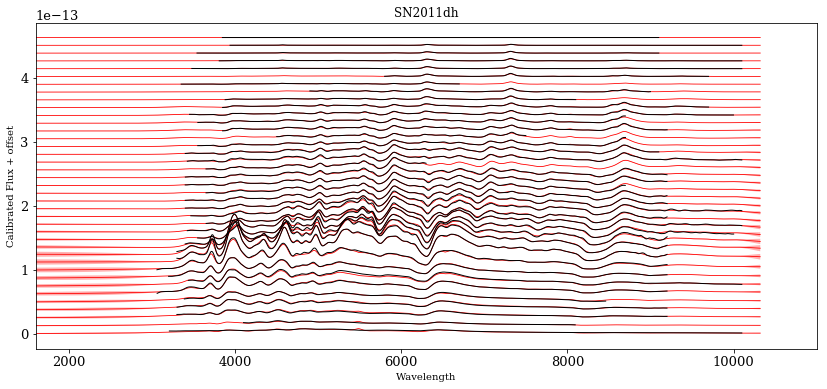

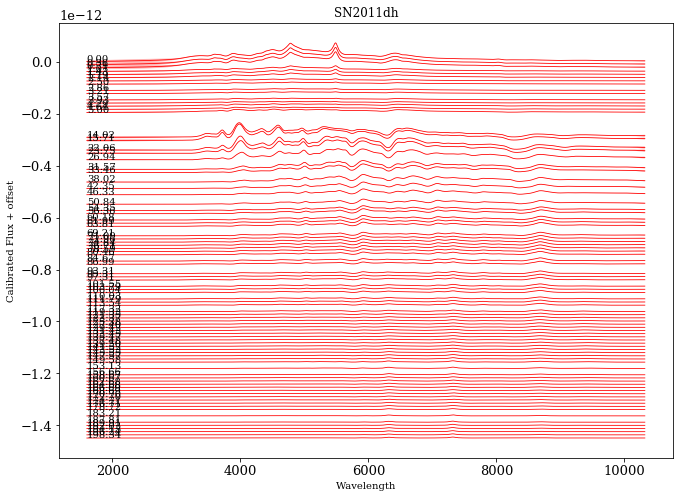

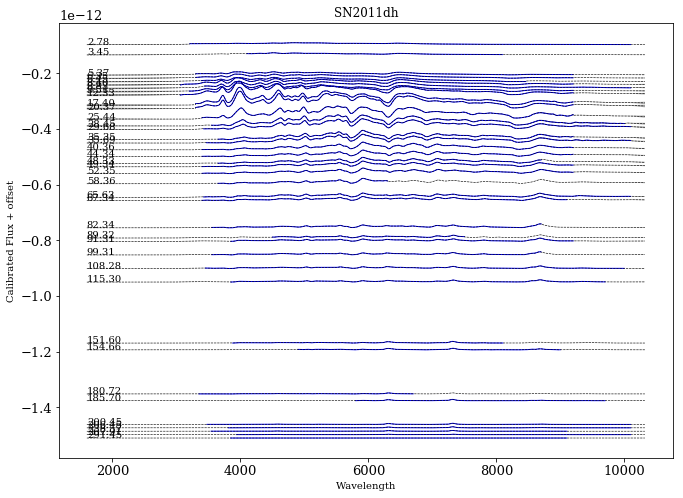

In [11]:

kernel_wls_scale = 0.05
kernel_time_scale = 0.3#0.5

for snname,type_ in sn_type_lista[:]:
    if snname in ['SN2011dh']:
        if type_ in ['Ib', 'Ic', 'Ic-BL', 'IcBL', 'IIb']: kernel_wls_scale = 0.01

        spec_class = FullMangledSeries_Class(main_path=DATALC_PATH, 
                                             snname=snname, type_=type_, mode='extrapolate_spectra',
                                             DELTA=30., verbose=False)
        raw_numbers, raw_numbers_err, off_xa, off_ya , grid_ext_columns = GP2dim.prepare_grid(snname, spec_class, )
        y_data_nonan, y_data_nonan_err, x1_data_norm,\
        x2_data_norm = GP2dim.transform2LOG_reshape(spec_class, raw_numbers, raw_numbers_err, off_xa, off_ya)
        GP2dim.make_plots(spec_class, y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm)
        Xprior, yprior = GP2dim.setPRIOR(spec_class, type_)
        
        x1_fill, x2_fill, mu_fill, std_fill = GP2dim.run_2DGP_GRID(spec_class, y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm,\
        		 kernel_wls_scale, kernel_time_scale, grid_ext_columns, 
                 prior=True, points=Xprior, values=yprior)
        GP2dim.make_results_plots(spec_class, x1_fill, x2_fill, mu_fill, std_fill)
        mu_fill_conv, std_fill_conv, y_data_conv = GP2dim.transform_back_andPlot(spec_class, x1_fill, x2_fill, 
                                                                                 mu_fill, std_fill, y_data_nonan)
        GP2dim.save_plots_files(spec_class, grid_ext_columns, y_data_conv, x1_fill, x2_fill, 
                                mu_fill_conv, std_fill_conv)
        spec_class.mode = 'extend_spectra'
        GP2dim.save_plots_files(spec_class, grid_ext_columns, y_data_conv, x1_fill, x2_fill, 
                                mu_fill_conv, std_fill_conv)
    



In [ ]:
#### mycmap = plt.cm.viridis
mycmap.set_under('r')

fig = plt.figure(1, figsize=(8,4))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)

plt.scatter(spec_class.grid_norm_info['norm2']*x2_fill, 
	spec_class.grid_norm_info['norm1']*x1_fill, marker='s', s=18, 
            c=mu_fill_conv)#, vmin=10**-19, vmax=4.4*10**-15)
#plt.colorbar(label='Flux rescaled')

cb = plt.colorbar()
#cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=13)
cb.ax.set_ylabel(r'Flux $(erg$ $s^{-1} cm^{-2} \AA^{-1})$', fontsize=15)

#plt.savefig('gaussian_processes_2d_training_data.png', bbox_inches='tight')
#plt.subplot(122)
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='s', s=10,  c=std_fill_conv, alpha=1., 
#			vmin=0., cmap = mycmap)
##plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
##plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
#plt.xlabel('MJD')
#plt.ylabel('wls')
plt.ylim(1400, 10500)
plt.xlim(-1, 170)
plt.title('iPTF13bvn', fontsize=15)
plt.ylabel(r'Wavelength ($\AA$)', fontsize=15)
plt.xlabel(r'Days from first detection', fontsize=15)
#plt.title(spec_class.snname, fontsize=15)
#plt.grid()
plt.show()
fig.savefig(spec_class.save_plot_path+'/2d_surface_FINAL.png', bbox_inches='tight')
plt.close(fig)

In [16]:
spec_class.lam_eff('Bessell_U')

3591.5831211583077

In [ ]:
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 1080x288 with 0 Axes>

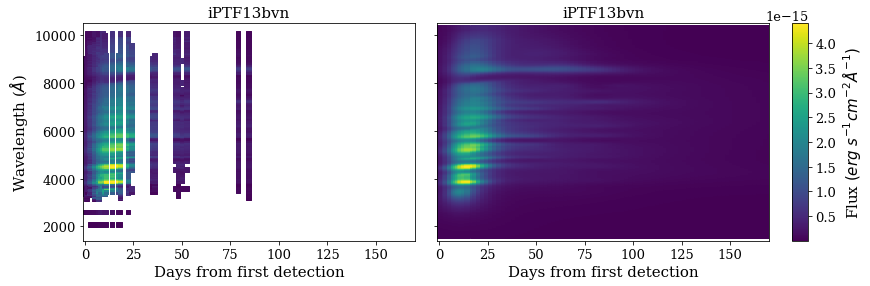

In [100]:

mycmap = plt.cm.viridis
mycmap.set_under('r')

fig = plt.figure(1, figsize=(15,4))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)

fig, (ax, ax2, cax) = plt.subplots(ncols=3,figsize=(13,4), 
                  gridspec_kw={"width_ratios":[1,1, 0.05]})
fig.subplots_adjust(wspace=0.1)

ax.scatter(x2_forplot, x1_forplot, marker='s', s=20, c=y_data_nonan_unscaled_forplot,
           vmin=10**-19, vmax=4.4*10**-15)

ax.set_ylim(1400, 10500)
ax.set_xlim(-1, 170)
ax.set_ylabel(r'Wavelength ($\AA$)', fontsize=15)
ax.set_xlabel(r'Days from first detection', fontsize=15)
ax.set_title('iPTF13bvn', fontsize=15)

im = ax2.scatter(spec_class.grid_norm_info['norm2']*x2_fill, 
	spec_class.grid_norm_info['norm1']*x1_fill, marker='s', s=20, 
            c=mu_fill_conv, vmin=10**-19, vmax=4.4*10**-15)
#cb.ax.set_ylabel(r'Flux $(erg$ $s^{-1} cm^{-2} \AA^{-1})$', fontsize=15)

#plt.savefig('gaussian_processes_2d_training_data.png', bbox_inches='tight')
#plt.subplot(122)
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='s', s=10,  c=std_fill_conv, alpha=1., 
#			vmin=0., cmap = mycmap)
##plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
##plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
#plt.xlabel('MJD')
#plt.ylabel('wls')
ax2.tick_params(axis='y', labelleft='off')
ax2.set_ylim(1400, 10500)
ax2.set_xlim(-1, 170)
ax2.set_title('iPTF13bvn', fontsize=15)
ax2.set_xlabel(r'Days from first detection', fontsize=15)

fig.colorbar(im, cax=cax)
cax.set_ylabel(r'Flux $(erg$ $s^{-1} cm^{-2} \AA^{-1})$', fontsize=15)

plt.show()
fig.savefig(spec_class.save_plot_path+'/2d_surface_FINAL.png', bbox_inches='tight')
plt.close(fig)

In [ ]:

mycmap = plt.cm.viridis
mycmap.set_under('r')

fig = plt.figure(1, figsize=(7,4))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)

plt.scatter(spec_class.grid_norm_info['norm2']*x2_data_norm, 
	spec_class.grid_norm_info['norm1']*x1_data_norm, marker='s', s=13, c=y_data_nonan)
#plt.colorbar(label='Flux rescaled')

cb = plt.colorbar()
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=13)
cb.ax.set_ylabel('Scaled Flux', fontsize=15)

#plt.savefig('gaussian_processes_2d_training_data.png', bbox_inches='tight')
#plt.subplot(122)
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='s', s=10,  c=std_fill_conv, alpha=1., 
#			vmin=0., cmap = mycmap)
##plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
##plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
#plt.xlabel('MJD')
#plt.ylabel('wls')
plt.ylabel(r'Wavelength ($\AA$)', fontsize=15)
plt.xlabel(r'Days from first detection', fontsize=15)
plt.title(spec_class.snname+': two dimensional grid', fontsize=15)
plt.grid()
plt.show()
fig.savefig(spec_class.save_plot_path+'/2d_surface.png', bbox_inches='tight')
plt.close(fig)

In [ ]:
LOG = True
kernel_wls_scale = 0.2
for snname in ['iPTF13bvn']:
    print ((snname+' ')*10)
    save_plot_path = DATALC_PATH+'/results_template/%s/TwoDextended_spectra'%snname
    spec_test = FullMangledSeries_Class(main_path=DATALC_PATH, snname=snname, DELTA=30.)
    raw_numbers, raw_numbers_err, off_xa, off_ya , grid_ext_columns= prepare_grid(snname)
    y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm,\
        x1_data_new_norm, x2_data_new_norm, offset, \
        scale_factor, norm1, norm2, offset2 = transform2LOG_reshape(raw_numbers, raw_numbers_err)
    make_plots()
    x1_fill, x2_fill, mu_fill, std_fill = run_GP_on2D_GRID()
    mu_fill_conv, std_fill_conv, y_data_conv = transform_back_andPlot()
    save_plots_files()

In [ ]:
save_plots_files()

In [ ]:
# snname = 'SN1999dn'
# save_plot_path = DATALC_PATH+'/results_template/%s/TwoDextended_spectra'%snname
# spec_test = FullMangledSeries_Class(main_path=DATALC_PATH, snname=snname, DELTA=30.)
# LOG = True

In [ ]:
def prepare_grid(snname):
    lcfit = spec_test.open_LCfit_file()
    spec_test.get_filter_LC()
    xa, ya, grid_nt, griderr_nt = spec_test.grid_all_spectraltimeseries()
    xa_ext, ya_ext, grid_ext, griderr_ext = spec_test.extend_grid_all_spectraltimeseries()
    
    raw_numbers = grid_ext.values
    raw_numbers_err = griderr_ext.values
    off_xa = xa_ext
    off_ya = ya_ext
    return (raw_numbers, raw_numbers_err, off_xa, off_ya, grid_ext.columns.values)


In [ ]:
#raw_numbers, raw_numbers_err, off_xa, off_ya , grid_ext_columns= prepare_grid(snname)

## Trasform data to LOG, then rescale them to force them to be between 0,1 

## Reshape the grid to feed the 2dGP


In [ ]:
def transform2LOG_reshape(raw_numbers, raw_numbers_err):
    
    # Trasform to LOG
    data_lin = (raw_numbers.T.reshape(raw_numbers.shape[0]*raw_numbers.shape[1]))
    data_lin_err = (raw_numbers_err.T.reshape(raw_numbers_err.shape[0]*raw_numbers_err.shape[1]))
    
    data = np.copy(data_lin)
    data[data_lin<=0.] = np.nan
    
    if LOG:
        data = np.log(data)
        data_err = (data_lin_err/data_lin)
    else:
        data_err = np.copy(data_lin_err)
    
    data_err[data_lin<=0.] = np.nan
    
    offset = np.min(data[~np.isnan(data)])
    scale_factor = np.median(data[~np.isnan(data)] - offset)
    
    data_scaled = ((data - offset)/scale_factor)
    data_error_scaled = (data_err)/scale_factor#/((data - offset))

    ## Reshape the grid to feed the 2dGP
    x = []
    for i in range(raw_numbers.shape[1]):
        x = np.concatenate([x, np.arange(0,raw_numbers.shape[0],1)])
    y = []
    for i in range(raw_numbers.shape[1]):
        y = np.concatenate([y, np.ones(raw_numbers.shape[0])*i])
    
    resh_wls = []
    for i in range(raw_numbers.shape[1]):
        resh_wls = np.concatenate([resh_wls, off_xa])
    
    resh_mjd = []
    for i in off_ya:
        resh_mjd = np.concatenate([resh_mjd, np.ones(len(off_xa))*i])
    
    NOT_Isnan = (~np.isnan(data_scaled))&(~np.isnan(data_error_scaled))
    Isnan = (np.isnan(data_scaled))|(np.isnan(data_error_scaled))
    
    x1_data = resh_wls[NOT_Isnan]
    x2_data = resh_mjd[NOT_Isnan]
    
    x_tuble_nonan = np.array([i for i in zip(x1_data, x2_data)])
    y_data_nonan = np.copy(data_scaled[NOT_Isnan])
    y_data_nonan_err = np.copy(data_error_scaled[NOT_Isnan])
    
    x1_data_new = resh_wls[Isnan]
    x2_data_new = resh_mjd[Isnan]
    
    x_tuble_new = np.array([i for i in zip(x1_data_new, x2_data_new)])
    
    if not os.path.exists(save_plot_path):
        os.makedirs(save_plot_path)
    
    norm1 = 11000.#max(x1_data)
    offset2 = min(x2_data)
    norm2 = max(x2_data-offset2)
    
    x1_data_norm = (x1_data/norm1)
    x2_data_norm = (x2_data-offset2)/norm2
    
    x1_data_new_norm = x1_data_new/norm1
    x2_data_new_norm = (x2_data_new-offset2)/norm2
    
    return (y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm,\
            x1_data_new_norm, x2_data_new_norm, offset, scale_factor, norm1, norm2, offset2)

In [ ]:
#y_data_nonan, y_data_nonan_err, x1_data_norm, x2_data_norm,\
#            x1_data_new_norm, x2_data_new_norm, offset, scale_factor, norm1, norm2, offset2 = transform2LOG_reshape(raw_numbers, raw_numbers_err)

## PLOTS

In [ ]:

def make_plots():
    fig=plt.figure(1)
    plt.xlabel('MJD')
    plt.ylabel('wls')
    #plt.xlim(x1_min,x1_max)
    #plt.ylim(x2_min,x2_max)
    plt.title('Training Data')
    
    plt.grid(True)
    
    #plt.scatter(norm2*x2_data_new_norm, norm1*x1_data_new_norm, marker='.')
    
    plt.scatter(norm2*x2_data_norm, norm1*x1_data_norm, marker='s', s=9,c=y_data_nonan)
    plt.colorbar()
    #plt.savefig('gaussian_processes_2d_training_data.png', bbox_inches='tight')
    plt.show()
    fig.savefig(save_plot_path+'/data_for2d_interpolation.pdf', bbox_inches='tight')
    plt.close(fig)
    
    
    #fig=plt.figure(1, figsize=(12,7))
    plt.xlabel('MJD')
    plt.ylabel('wls')
    #plt.xlim(x1_min,x1_max)
    #plt.ylim(x2_min,x2_max)
    plt.title('Training Data')
    
    plt.grid(True)
    
    #plt.scatter(norm2*x2_data_new_norm, norm1*x1_data_new_norm, marker='.')
    
    plt.scatter(norm2*x2_data_norm, norm1*x1_data_norm, marker='s', s=10, \
                c=np.log10(y_data_nonan_err))
    plt.colorbar()
    #plt.savefig('gaussian_processes_2d_training_data.png', bbox_inches='tight=4,
    plt.show()

In [ ]:
#make_plots()

## 2d GP

In [ ]:
mycmap = plt.cm.viridis
mycmap.set_under('r')

def run_GP_on2D_GRID():
    X = np.vstack((x1_data_norm, x2_data_norm)).T
    y = y_data_nonan
    yerr = y_data_nonan_err
    
    kernel_mix = Matern32Kernel([kernel_wls_scale, 0.7], ndim=2)
    kernel2dim = np.var(y)*kernel_mix #+ 0.3*np.var(y)*kernel2*kernel1
    
    gp = george.GP(kernel2dim)#, fit_mean=True, fit_white_noise=True)
    gp.compute(X, yerr)
        
    X_new = np.vstack((x1_data_new_norm, x2_data_new_norm)).T
    
    wls_normed_range = np.sort(np.concatenate(( np.arange(1600.,3000., 40),
                                              np.arange(3000.,9000., 10),
                                              np.arange(9000.,10350., 40))))/norm1

    mu_fill_resh = []
    std_fill_resh = []
    
    slot_size = 3
    extrap_mjds = grid_ext_columns
    for j in range(int(len(extrap_mjds)/slot_size+1)):
        mjd_normed_range = ((extrap_mjds[j*slot_size:(j+1)*slot_size])-offset2)/norm2
        x1_fill = []#np.random.permutation(np.linspace(0,1., N))
        x2_fill = []#np.random.permutation(np.linspace(0,1., N))
        for i in wls_normed_range:
            for k in mjd_normed_range:
                x1_fill.append(i)
                x2_fill.append(k)
        
        x1_fill=np.array(x1_fill) 
        x2_fill=np.array(x2_fill)
        
        X_fill = np.vstack((x1_fill, x2_fill)).T
        print (X_fill.shape)
    
        print (j, 'of', int(len(extrap_mjds)/slot_size+1))
        mu_iter, cov_iter = (gp.predict(y, X_fill, return_cov=True))
        std_iter = np.sqrt(np.diag(cov_iter))
        
        mu_resh_iter = mu_iter.reshape(len(wls_normed_range), len(mjd_normed_range))
        std_resh_iter = std_iter.reshape(len(wls_normed_range), len(mjd_normed_range))
    
        if mu_fill_resh==[]:
            mu_fill_resh = np.copy(mu_resh_iter)
            std_fill_resh = np.copy(std_resh_iter)
        else:
            mu_fill_resh = np.concatenate([mu_fill_resh, mu_resh_iter], axis=1)
            std_fill_resh = np.concatenate([std_fill_resh, std_resh_iter], axis=1)
            
    mu_fill = mu_fill_resh.reshape(len(wls_normed_range)*len(extrap_mjds))
    std_fill = std_fill_resh.reshape(len(wls_normed_range)*len(extrap_mjds))

    mjd_normed_range = (extrap_mjds-offset2)/norm2
    
    x1_fill = []#np.random.permutation(np.linspace(0,1., N))
    x2_fill = []#np.random.permutation(np.linspace(0,1., N))
    for i in wls_normed_range:
        for k in mjd_normed_range:
            x1_fill.append(i)
            x2_fill.append(k)
    
    x1_fill=np.array(x1_fill) 
    x2_fill=np.array(x2_fill)
    
    print ('EXTENDING SPECTRA BETWEEN:')
    print ('WLS:', min(x1_fill*norm1), max(x1_fill*norm1))
    print ('MJD:', min(x2_fill*norm2), max(x2_fill*norm2))

    return (x1_fill, x2_fill, mu_fill, std_fill)

In [ ]:
#x1_fill, x2_fill, mu_fill, std_fill = run_GP_on2D_GRID()

In [ ]:
def make_results_plots():
    plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='.', c=mu_fill, alpha=1., 
            vmin=0., cmap = mycmap)
    #plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
    #plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
    plt.xlabel('MJD')
    plt.ylabel('wls')
    plt.colorbar()
    
    # PLOT xWLS LC and check how smooth the time variation in each single wls is:
    fit_wls = (np.unique(x1_fill)[::10])
    len_wls = len(fit_wls)
    
    color=cycle(plt.cm.gnuplot(np.linspace(0.05,0.95,len_wls)))
    
    fig = plt.figure(figsize=(10,6))
    plt.subplot(221)
    plt.title('from %.1f to %.1f'%(min(fit_wls[:int(len_wls/4)]*norm1),max(fit_wls[:int(len_wls/4)]*norm1)))
    for i in fit_wls[:int(len_wls/4)]:
        mask = x1_fill==i
        plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
                 lw=3, color=next(color), label='%i'%(i*norm1))
    plt.subplot(222)
    plt.title('from %.1f to %.1f'%(min(fit_wls[int(len_wls/4):2*int(len_wls/4)]*norm1),max(fit_wls[int(len_wls/4):2*int(len_wls/4)]*norm1)))
    for i in fit_wls[int(len_wls/4):2*int(len_wls/4)]:
        mask = x1_fill==i
        plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
                 lw=3, color=next(color), label='%i'%(i*norm1))
    
    plt.subplot(223)
    plt.title('from %.1f to %.1f'%(min(fit_wls[2*int(len_wls/4):3*int(len_wls/4)]*norm1),max(fit_wls[2*int(len_wls/4):3*int(len_wls/4)]*norm1)))
    for i in fit_wls[2*int(len_wls/4):3*int(len_wls/4)]:
        mask = x1_fill==i
        plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
                 lw=3, color=next(color), label='%i'%(i*norm1))
    
    plt.subplot(224)
    plt.title('from %.1f to %.1f'%(min(fit_wls[3*int(len_wls/4):int(len_wls)]*norm1),max(fit_wls[3*int(len_wls/4):int(len_wls)]*norm1)))
    for i in fit_wls[3*int(len_wls/4):int(len_wls)]:
    
        mask = x1_fill==i
        plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
                 lw=3, color=next(color), label='%i'%(i*norm1))
    plt.show()



In [ ]:
def transform_back_andPlot():
    if LOG:
        mu_fill_conv = np.exp(mu_fill*scale_factor + offset)
        std_fill_conv = np.abs( scale_factor*mu_fill_conv *std_fill )
    
        y_data_conv = np.exp(y_data_nonan*scale_factor + offset)
    else:
        mu_fill_conv = (mu_fill*scale_factor + offset)
        std_fill_conv = np.abs( scale_factor*std_fill )
    
        y_data_conv =(y_data_nonan*scale_factor + offset)
        
    fig = plt.figure(1)
    plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='s', s=10,  c=mu_fill_conv, alpha=1., 
                vmin=0., cmap = mycmap)
    #plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
    #plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
    plt.xlabel('MJD')
    plt.ylabel('wls')
    plt.colorbar()
    plt.show()
    fig.savefig(save_plot_path+'/2d_surface.png', bbox_inches='tight')
    plt.close(fig)
    
    fig = plt.figure(1)
    plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='s', s=10,  c=std_fill_conv, alpha=1., 
                vmin=0., cmap = mycmap)
    #plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
    #plt.scatter(x2_data_norm, x1_data_norm, marker='s', c=y_data)
    plt.xlabel('MJD')
    plt.ylabel('wls')
    plt.colorbar()
    plt.show()
    fig.savefig(save_plot_path+'/2d_surface_err.png', bbox_inches='tight')
    plt.close(fig)
    
    max_val = np.max(raw_numbers[~np.isnan(raw_numbers)])
    med_val = np.median(raw_numbers[~np.isnan(raw_numbers)])
    
    fig = plt.figure(1, figsize=(8,4))
    spec_mjd_list = spec_test.get_spec_mjd()
    scale = (max_val-med_val)/5.
    a=0
    for j in range(len(spec_test.get_spec_mjd())):
        mj = spec_mjd_list[j]
        a +=1
    a=0
    mangled_original_list = spec_test.mangledspec_list
    
    for j in range(len(spec_test.get_spec_mjd())):
        mj = spec_mjd_list[j]
        spec_file_original = spec_test.load_mangledfile(mangled_original_list[j])
        a +=1
        #mask = x2_fill==(mj-offset2)/norm2
        #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask], label='%i'%(mj-offset2), lw=0.8, color='r')
        #plt.plot(off_xa, grid_ext[mj]+(a-1)*scale, label='Raw spec %i'%(mj-offset2), lw=1.8, color='k')
        plt.plot(spec_file_original['wls'], spec_file_original['flux']+(a-1)*scale,
                 label='Raw spec %i'%(mj-offset2), lw=1.0, color='k')

    for b in spec_test.avail_filters:
        #plt.vlines((spec_test.lam_eff(b)), 0, max_val, linestyle='--', lw=1, label=b, color=color_dict[b])
        wls, T = spec_test.get_filt_transmission(b)
        plt.plot(wls, 0.5*T*max_val/max(T), linestyle='-', lw=2, color=color_dict[b])

    plt.xlim(1600,11000)
    plt.title(snname)
    plt.xlabel('Wavelength')
    plt.ylabel('Calibrated Flux + offset')
    fig.savefig(save_plot_path+'/to_be_extended_spec1.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    fig = plt.figure(1, figsize=(8,5))

    spec_mjd_list = spec_test.get_spec_mjd()
    scale = (max_val-med_val)/5.
    a=0
    for j in range(len(spec_test.get_spec_mjd())):
        mj = spec_mjd_list[j]
        a +=1
        mask = x2_fill==(mj-offset2)/norm2
        plt.plot(x1_fill[mask]*norm1, mu_fill[mask]+(a-1)*scale, 
                 label='Extrapolated %i'%(mj-offset2), lw=0.8, color='r')
        plt.fill_between(x1_fill[mask]*norm1, (mu_fill[mask]-std_fill[mask])+(a-1)*scale , 
                 (mu_fill[mask]+std_fill[mask])+(a-1)*scale , facecolor='r', alpha=0.3)
    
    plt.xlim(1600,11000)
    for b in spec_test.avail_filters:
        plt.vlines((spec_test.lam_eff(b)), 0, 1., linestyle='--', lw=4, label=b, color=color_dict[b])

    plt.title(spec_test.snname)
    plt.xlabel('Wavelength')
    plt.ylabel('Calibrated Flux + offset')
    fig.savefig(save_plot_path+'/extended_spec_LOG_SPACE.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    fig = plt.figure(1, figsize=(8,5))
    spec_mjd_list = spec_test.get_spec_mjd()
    scale = (max_val-med_val)/5.
    a=0
    for j in range(len(spec_test.get_spec_mjd())):
        mj = spec_mjd_list[j]
        a +=1
        mask = x2_fill==(mj-offset2)/norm2
        plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask]+(a-1)*scale, 
                 label='Extrapolated %i'%(mj-offset2), lw=0.8, color='r')
        plt.fill_between(x1_fill[mask]*norm1, (mu_fill_conv[mask]-std_fill_conv[mask])+(a-1)*scale , 
                 (mu_fill_conv[mask]+std_fill_conv[mask])+(a-1)*scale , facecolor='r', alpha=0.3)
    a=0    
    mangled_original_list = spec_test.mangledspec_list
    
    for j in range(len(spec_test.get_spec_mjd())):
        mj = spec_mjd_list[j]
        spec_file_original = spec_test.load_mangledfile(mangled_original_list[j])
        a +=1
        mask = x2_fill==(mj-offset2)/norm2
        #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask], label='%i'%(mj-offset2), lw=0.8, color='r')
        #plt.plot(off_xa, grid_ext[mj]+(a-1)*scale, label='Raw spec %i'%(mj-offset2), lw=1.8, color='k')
        plt.plot(spec_file_original['wls'], spec_file_original['flux']+(a-1)*scale,
                 label='Raw spec %i'%(mj-offset2), lw=1, color='k')
    
    plt.xlim(1600,11000)
    
    for b in spec_test.avail_filters:
        #plt.vlines((spec_test.lam_eff(b)), 0, max_val, linestyle='--', lw=1, label=b, color=color_dict[b])
        wls, T = spec_test.get_filt_transmission(b)
        plt.plot(wls, 0.5*T*max_val/max(T), linestyle='-', lw=4, color=color_dict[b])
    plt.title(spec_test.snname)
    plt.xlabel('Wavelength')
    plt.ylabel('Calibrated Flux + offset')
    fig.savefig(save_plot_path+'/extended_spec.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    return (mu_fill_conv, std_fill_conv, y_data_conv)

In [ ]:
#mu_fill_conv, std_fill_conv, y_data_conv = transform_back_andPlot()

In [ ]:
def save_plots_files():
    results_directory = spec_test.main_path+'/results_template/%s/'%spec_test.snname
    fig = plt.figure(1, figsize=(11,8))
    
    max_val = np.max(raw_numbers[~np.isnan(raw_numbers)])
    med_val = np.median(raw_numbers[~np.isnan(raw_numbers)])

    scale = (max_val-med_val)/5.
    list_mjds_tot = grid_ext_columns
    list_mjds_spec = np.array(spec_test.get_spec_mjd())
    list_mjds_spec_file = np.array(spec_test.mangledspec_list)
    if snname=='iPTF13bvn':
        list_mjds_spec_special = np.array([56463.43, 56468.42, 56473.39, 56476.31, 56478.35,
                       56481.34, 56483.36, 56486.33, 56488.35, 56493.29])

    min_mjd = min(list_mjds_tot)
    a=0
    for j in range(len(list_mjds_tot)):
        mj = list_mjds_tot[j]
        mask = x2_fill==(mj-offset2)/norm2
        wls = x1_fill[mask]*norm1
        smooth_ext_spec = mu_fill_conv[mask]
        smooth_ext_spec_err = std_fill_conv[mask]

        a = a-1

        if mj in list_mjds_spec:
            file = list_mjds_spec_file[np.where(list_mjds_spec==mj)[0]][0]
            spec_orig = spec_test.load_mangledfile(file)
            UV_mask = (wls<min(spec_orig['wls']))
            IR_mask = (wls>max(spec_orig['wls']))
            ext_spec_wls = np.concatenate((wls[UV_mask], 
                                           spec_orig['wls'], 
                                           wls[IR_mask]))
            ext_spec_flx = np.concatenate((smooth_ext_spec[UV_mask], 
                                           spec_orig['flux'], 
                                           smooth_ext_spec[IR_mask]))
            ext_spec_flx_err = np.concatenate((smooth_ext_spec_err[UV_mask], 
                                               spec_orig['fluxerr'], 
                                               smooth_ext_spec_err[IR_mask]))

            plt.plot(spec_orig['wls'], spec_orig['flux']+(a+1)*scale, lw=1, color='b')
            plt.plot(ext_spec_wls, ext_spec_flx+(a+1)*scale, lw=0.6, color='k', linestyle='--')
            plt.fill_between(ext_spec_wls, 
                             (ext_spec_flx-ext_spec_flx_err)+(a+1)*scale, 
                             (ext_spec_flx+ext_spec_flx_err)+(a+1)*scale, 
                             alpha=0.3, facecolor='k')

            plt.text(ext_spec_wls[0], (a+1)*scale, '%.2f'%(mj-min_mjd))
            # write the file
            fout = open(results_directory+'TwoDextended_spectra'+'/%.2f_spec_extended.txt'%mj, 'w')
            fout.write('#wls\tflux\tfluxerr\n')
            for w,f,ferr in zip(ext_spec_wls, ext_spec_flx,ext_spec_flx_err):
                fout.write('%E\t%E\t%E\n'%(w,f,ferr))
            fout.close()
            
        else:
            plt.plot(wls, smooth_ext_spec+(a+1)*scale, label='Extrapolated %i'%(mj-offset2), lw=0.8, color='r')
            plt.fill_between(wls, (smooth_ext_spec-smooth_ext_spec_err)+(a+1)*scale,
                             (smooth_ext_spec+smooth_ext_spec_err)+(a+1)*scale,
                             alpha=0.3, facecolor='r')
            plt.text(wls[0], (a+1)*scale, '%.2f'%(mj-min_mjd))
            fout = open(results_directory+'TwoDextended_spectra'+'/%.2f_spec_extended_FL.txt'%mj, 'w')
            fout.write('#wls\tflux\tfluxerr\n')
            for w,f,ferr in zip(wls, smooth_ext_spec, smooth_ext_spec_err):
                fout.write('%E\t%E\t%E\n'%(w,f,ferr))
            fout.close()
    plt.xlabel('Wavelength')
    plt.ylabel('Calibrated Flux + offset')
    plt.title(snname)
    fig.savefig(save_plot_path+'/extended_spec_plusFL.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

    if snname=='iPTF13bvn':
        min_mjd = min(list_mjds_spec_special)
        for j in range(len(list_mjds_spec_special)):
            mj = list_mjds_spec_special[j]
            mask = x2_fill==(mj-offset2)/norm2
            wls = x1_fill[mask]*norm1
            smooth_ext_spec = mu_fill_conv[mask]
            smooth_ext_spec_err = std_fill_conv[mask]

            a = a-1
            #plt.plot(wls, smooth_ext_spec+(a+1)*scale, label='SNF %i'%(mj-offset2), lw=0.8, color='r')
            #plt.fill_between(wls, (smooth_ext_spec-smooth_ext_spec_err)+(a+1)*scale,
                             #(smooth_ext_spec+smooth_ext_spec_err)+(a+1)*scale,
                             #alpha=0.3, facecolor='r')

            #plt.text(ext_spec_wls[0], (a+1)*scale, '%.2f'%(mj-min_mjd))
            fout = open(results_directory+'TwoDextended_spectra'+'/%.2f_spec_extended_SNF.txt'%mj, 'w')
            fout.write('#wls\tflux\tfluxerr\n')
            for w,f,ferr in zip(wls, smooth_ext_spec, smooth_ext_spec_err):
                fout.write('%E\t%E\t%E\n'%(w,f,ferr))
            fout.close()

            
#save_plots_files()

In [ ]:
#kernel1 = Matern32Kernel([0.005], ndim=2, axes=0)
#kernel2 = ExpSquaredKernel([5], ndim=2, axes=1)

#kernel_mix = Matern32Kernel([0.05, 0.7], ndim=2)

#kernel2dim = np.var(y)*kernel_mix + np.var(y)*kernel2*kernel1
#kernel2dim = 0.3*np.var(y)*kernel_mix + 0.7*np.var(y)*kernel2*kernel1
#kernel2dim = np.var(y)*kernel_mix #+ 0.3*np.var(y)*kernel2*kernel1

In [ ]:
#gp = george.GP(kernel2dim)#, fit_mean=True, fit_white_noise=True)
#gp.compute(X, yerr)
#
#from scipy.optimize import minimize
#
#def nll(params):
#    #print (np.exp(params))
#    gp.set_parameter_vector(params)
#    l = gp.log_likelihood(y, quiet=True)
#    g = gp.grad_log_likelihood(y, quiet=True)
#    print (["{0:0.2e}".format(i) for i in g])
#    if np.any(np.abs(np.array(g))<10**-10):
#        print ('THIS IS NOT CONVERGING')
#    return -l, -g
#
#def ll(params):
#    gp.set_parameter_vector(params)
#    param_dict = gp.get_parameter_dict()
#    #print ('log_M_0_0', np.exp(param_dict['kernel:k1:k2:metric:log_M_0_0']))
#    ##print ('log_M_1_1', np.exp(param_dict['kernel:k1:k2:metric:log_M_1_1']))
#    #if ((np.exp(param_dict['kernel:k1:k2:metric:log_M_0_0'])<0.00001)|(np.exp(param_dict['kernel:k1:k2:metric:log_M_1_1'])<0.00001)):
#    #    print ('No good')
#    #    return -np.inf
#    #else:
#    return -gp.lnlikelihood(y, quiet=False)#
## gradient of the  liklihood for optimisation of the kernel size
#
#def grad_ll(params):
#    gp.set_parameter_vector(params)
#    g = gp.grad_lnlikelihood(y, quiet=True)
#    print (["{0:0.2e}".format(i) for i in g])
#    if np.any(np.abs(np.array(g))<10**-10):
#        print ('THIS IS NOT CONVERGING')
#    return -gp.grad_lnlikelihood(y, quiet=False)
#        
#params = gp.get_parameter_vector()
#print (np.exp(params))
#soln = minimize(ll, params, jac=grad_ll)
#soln = minimize(nll, params, jac=True)
#gp.set_parameter_vector(soln.x)
#print(soln.success, np.exp(soln.x))


In [ ]:
#try:
#    print(soln.success)
#    for k,v in zip(gp.get_parameter_dict().items(), params):
#        print ('%.4f'%np.exp(k[1]),'%.4f'%np.exp(v), k[0])
#        print (k[1])
#except:
#    print ('No opt')

In [ ]:
#X_new = np.vstack((x1_data_new_norm, x2_data_new_norm)).T
#
#wls_normed_range = np.sort(np.concatenate(( np.arange(1600.,3000., 40),
#                                          np.arange(3000.,9000., 10),
#                                          np.arange(9000.,10350., 40))))/norm1
#
#mu_fill_resh = []
#std_fill_resh = []
#
#slot_size = 3
#extrap_mjds = grid_ext.columns.values
#for j in range(int(len(extrap_mjds)/slot_size+1)):
#    mjd_normed_range = ((extrap_mjds[j*slot_size:(j+1)*slot_size])-offset2)/norm2
#    x1_fill = []#np.random.permutation(np.linspace(0,1., N))
#    x2_fill = []#np.random.permutation(np.linspace(0,1., N))
#    for i in wls_normed_range:
#        for k in mjd_normed_range:
#            x1_fill.append(i)
#            x2_fill.append(k)
#    
#    x1_fill=np.array(x1_fill) 
#    x2_fill=np.array(x2_fill)
#    
#    X_fill = np.vstack((x1_fill, x2_fill)).T
#    print (X_fill.shape)
#
#    print (j, 'of', int(len(extrap_mjds)/slot_size+1))
#    mu_iter, cov_iter = (gp.predict(y, X_fill, return_cov=True))
#    std_iter = np.sqrt(np.diag(cov_iter))
#    
#    mu_resh_iter = mu_iter.reshape(len(wls_normed_range), len(mjd_normed_range))
#    std_resh_iter = std_iter.reshape(len(wls_normed_range), len(mjd_normed_range))
#
#    if mu_fill_resh==[]:
#        mu_fill_resh = np.copy(mu_resh_iter)
#        std_fill_resh = np.copy(std_resh_iter)
#    else:
#        mu_fill_resh = np.concatenate([mu_fill_resh, mu_resh_iter], axis=1)
#        std_fill_resh = np.concatenate([std_fill_resh, std_resh_iter], axis=1)
#        
#mu_fill = mu_fill_resh.reshape(len(wls_normed_range)*len(extrap_mjds))
#std_fill = std_fill_resh.reshape(len(wls_normed_range)*len(extrap_mjds))
#
#mycmap = plt.cm.viridis
#mycmap.set_under('r')
#

#if snname=='iPTF13bvn':
#    list_mjds_spec_special = []#np.array([56463.43, 56468.42, 56473.39, 56476.31, 56478.35,
#                      # 56481.34, 56483.36, 56486.33, 56488.35, 56493.29])
#
#    x1_fill = []#np.random.permutation(np.linspace(0,1., N))
#    x2_fill = []#np.random.permutation(np.linspace(0,1., N))
#    
#    spec_mjds = grid_ext.columns.values
#    mjd_normed_range = np.sort(np.concatenate(( np.linspace(0.,1., int(N_mjd/4.)),(spec_mjds-offset2)/norm2,
#                                             (list_mjds_spec_special-offset2)/norm2)))
#
#    for i in wls_normed_range:
#        for j in mjd_normed_range:
#            x1_fill.append(i)
#            x2_fill.append(j)

In [ ]:
#mjd_normed_range = (extrap_mjds-offset2)/norm2
#
#x1_fill = []#np.random.permutation(np.linspace(0,1., N))
#x2_fill = []#np.random.permutation(np.linspace(0,1., N))
#for i in wls_normed_range:
#    for k in mjd_normed_range:
#        x1_fill.append(i)
#        x2_fill.append(k)
#
#x1_fill=np.array(x1_fill) 
#x2_fill=np.array(x2_fill)


In [ ]:
#from itertools import cycle
#
#fit_wls = (np.unique(x1_fill)[::10])
#len_wls = len(fit_wls)
#
#color=cycle(plt.cm.gnuplot(np.linspace(0.05,0.95,len_wls)))
#
#fig = plt.figure(figsize=(10,6))
#plt.subplot(221)
#plt.title('from %.1f to %.1f'%(min(fit_wls[:int(len_wls/4)]*norm1),max(fit_wls[:int(len_wls/4)]*norm1)))
#for i in fit_wls[:int(len_wls/4)]:
#    mask = x1_fill==i
#    plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
#             lw=3, color=next(color), label='%i'%(i*norm1))
#plt.subplot(222)
#plt.title('from %.1f to %.1f'%(min(fit_wls[int(len_wls/4):2*int(len_wls/4)]*norm1),max(fit_wls[int(len_wls/4):2*int(len_wls/4)]*norm1)))
#for i in fit_wls[int(len_wls/4):2*int(len_wls/4)]:
#    mask = x1_fill==i
#    plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
#             lw=3, color=next(color), label='%i'%(i*norm1))
#
#plt.subplot(223)
#plt.title('from %.1f to %.1f'%(min(fit_wls[2*int(len_wls/4):3*int(len_wls/4)]*norm1),max(fit_wls[2*int(len_wls/4):3*int(len_wls/4)]*norm1)))
#for i in fit_wls[2*int(len_wls/4):3*int(len_wls/4)]:
#    mask = x1_fill==i
#    plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
#             lw=3, color=next(color), label='%i'%(i*norm1))
#
#plt.subplot(224)
#plt.title('from %.1f to %.1f'%(min(fit_wls[3*int(len_wls/4):int(len_wls)]*norm1),max(fit_wls[3*int(len_wls/4):int(len_wls)]*norm1)))
#for i in fit_wls[3*int(len_wls/4):int(len_wls)]:
#
#    mask = x1_fill==i
#    plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
#             lw=3, color=next(color), label='%i'%(i*norm1))
#
##plt.legend()

In [ ]:
#from itertools import cycle
#
#fit_wls = (np.unique(x1_fill)[::10])
#len_wls = len(fit_wls)
#
#color=cycle(plt.cm.gnuplot(np.linspace(0.05,0.95,len_wls)))
#
#fig = plt.figure(figsize=(10,6))
#plt.subplot(221)
#plt.title('from %.1f to %.1f'%(min(fit_wls[:int(len_wls/4)]*norm1),max(fit_wls[:int(len_wls/4)]*norm1)))
#for i in fit_wls[:int(len_wls/4)]:
#    mask = x1_fill==i
#    plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
#             lw=3, color=next(color), label='%i'%(i*norm1))
#plt.yscale('log')
#plt.subplot(222)
#plt.title('from %.1f to %.1f'%(min(fit_wls[int(len_wls/4):2*int(len_wls/4)]*norm1),max(fit_wls[int(len_wls/4):2*int(len_wls/4)]*norm1)))
#for i in fit_wls[int(len_wls/4):2*int(len_wls/4)]:
#    mask = x1_fill==i
#    plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
#             lw=3, color=next(color), label='%i'%(i*norm1))
#
#plt.yscale('log')
#plt.subplot(223)
#plt.title('from %.1f to %.1f'%(min(fit_wls[2*int(len_wls/4):3*int(len_wls/4)]*norm1),max(fit_wls[2*int(len_wls/4):3*int(len_wls/4)]*norm1)))
#for i in fit_wls[2*int(len_wls/4):3*int(len_wls/4)]:
#    mask = x1_fill==i
#    plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
#             lw=3, color=next(color), label='%i'%(i*norm1))
#
#plt.yscale('log')
#plt.subplot(224)
#plt.title('from %.1f to %.1f'%(min(fit_wls[3*int(len_wls/4):int(len_wls)]*norm1),max(fit_wls[3*int(len_wls/4):int(len_wls)]*norm1)))
#for i in fit_wls[3*int(len_wls/4):int(len_wls)]:
#
#    mask = x1_fill==i
#    plt.plot((x2_fill[mask])*norm2+offset2, np.exp(mu_fill[mask]*scale_factor + offset), 
#             lw=3, color=next(color), label='%i'%(i*norm1))
#plt.yscale('log')
##plt.legend()

In [ ]:
#for i in np.unique(x2_fill)[::10]:
#    mask = x2_fill==i
#    plt.plot(x1_fill[mask]*norm1, np.exp(mu_fill[mask]*scale_factor + offset), label='%i'%(i*norm2))
#plt.legend(fontsize=10)

In [ ]:
##fig = plt.figure(1, figsize=(13,9))
#fig = plt.figure(1, figsize=(8,4))
#spec_mjd_list = spec_test.get_spec_mjd()
#scale = (max_val-med_val)/5.
#a=0
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    a +=1
#a=0
#mangled_original_list = spec_test.mangledspec_list
#
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    spec_file_original = spec_test.load_mangledfile(mangled_original_list[j])
#    a +=1
#    #mask = x2_fill==(mj-offset2)/norm2
#    #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask], label='%i'%(mj-offset2), lw=0.8, color='r')
#    #plt.plot(off_xa, grid_ext[mj]+(a-1)*scale, label='Raw spec %i'%(mj-offset2), lw=1.8, color='k')
#    plt.plot(spec_file_original['wls'], spec_file_original['flux']+(a-1)*scale,
#             label='Raw spec %i'%(mj-offset2), lw=1.0, color='k')
#
#plt.xlim(1600,11000)
#plt.title(spec_test.snname)
#plt.xlabel('Wavelength')
#plt.ylabel('Calibrated Flux + offset')
#fig.savefig(save_plot_path+'/to_be_extended_spec.pdf', bbox_inches='tight')
#plt.show()
#plt.close(fig)

In [ ]:
##fig = plt.figure(1, figsize=(13,9))
#fig = plt.figure(1, figsize=(8,4))
#
#
#spec_mjd_list = spec_test.get_spec_mjd()
#scale = (max_val-med_val)/5.
#a=0
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    a +=1
#    #mask = x2_fill==(mj-offset2)/norm2
#    #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask]+(a-1)*scale, 
#    #         label='Extrapolated %i'%(mj-offset2), lw=0.8, color='r')
##plt.legend()
#
#a=0
#
#mangled_original_list = spec_test.mangledspec_list
#
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    spec_file_original = spec_test.load_mangledfile(mangled_original_list[j])
#    a +=1
#    #mask = x2_fill==(mj-offset2)/norm2
#    #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask], label='%i'%(mj-offset2), lw=0.8, color='r')
#    #plt.plot(off_xa, grid_ext[mj]+(a-1)*scale, label='Raw spec %i'%(mj-offset2), lw=1.8, color='k')
#    plt.plot(spec_file_original['wls'], spec_file_original['flux']+(a-1)*scale,
#             label='Raw spec %i'%(mj-offset2), lw=1.0, color='k')
#
#plt.xlim(1600,11000)
#
#for b in spec_test.avail_filters:
#    if ('swift' not in b)&('U' not in b):
#    #plt.vlines((spec_test.lam_eff(b)), 0, max_val, linestyle='--', lw=1, label=b, color=color_dict[b])
#        wls, T = spec_test.get_filt_transmission(b)
#        plt.plot(wls, 0.5*T*max_val/max(T), linestyle='-', lw=2, color=color_dict[b])
#
#plt.title(spec_test.snname)
#plt.xlabel('Wavelength')
#plt.ylabel('Calibrated Flux + offset')
#fig.savefig(save_plot_path+'/to_be_extended_spec1_nouv.pdf', bbox_inches='tight')
#plt.show()
#plt.close(fig)

In [ ]:
##fig = plt.figure(1, figsize=(13,9))
#fig = plt.figure(1, figsize=(8,4))
#
#
#spec_mjd_list = spec_test.get_spec_mjd()
#scale = (max_val-med_val)/5.
#a=0
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    a +=1
#    #mask = x2_fill==(mj-offset2)/norm2
#    #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask]+(a-1)*scale, 
#    #         label='Extrapolated %i'%(mj-offset2), lw=0.8, color='r')
##plt.legend()
#
#a=0
#
#mangled_original_list = spec_test.mangledspec_list
#
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    spec_file_original = spec_test.load_mangledfile(mangled_original_list[j])
#    a +=1
#    #mask = x2_fill==(mj-offset2)/norm2
#    #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask], label='%i'%(mj-offset2), lw=0.8, color='r')
#    #plt.plot(off_xa, grid_ext[mj]+(a-1)*scale, label='Raw spec %i'%(mj-offset2), lw=1.8, color='k')
#    plt.plot(spec_file_original['wls'], spec_file_original['flux']+(a-1)*scale,
#             label='Raw spec %i'%(mj-offset2), lw=1.0, color='k')
#
#plt.xlim(1600,11000)
#
#for b in spec_test.avail_filters:
#    #plt.vlines((spec_test.lam_eff(b)), 0, max_val, linestyle='--', lw=1, label=b, color=color_dict[b])
#    wls, T = spec_test.get_filt_transmission(b)
#    plt.plot(wls, 0.5*T*max_val/max(T), linestyle='-', lw=2, color=color_dict[b])
#
#plt.title(spec_test.snname)
#plt.xlabel('Wavelength')
#plt.ylabel('Calibrated Flux + offset')
#fig.savefig(save_plot_path+'/to_be_extended_spec1.pdf', bbox_inches='tight')
#plt.show()
#plt.close(fig)

In [ ]:
#fig = plt.figure(1, figsize=(13,9))
#fig = plt.figure(1, figsize=(8,5))
#
#spec_mjd_list = spec_test.get_spec_mjd()
#scale = (max_val-med_val)/5.
#a=0
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    a +=1
#    mask = x2_fill==(mj-offset2)/norm2
#    plt.plot(x1_fill[mask]*norm1, mu_fill[mask]+(a-1)*scale, 
#             label='Extrapolated %i'%(mj-offset2), lw=0.8, color='r')
#    plt.fill_between(x1_fill[mask]*norm1, (mu_fill[mask]-std_fill[mask])+(a-1)*scale , 
#             (mu_fill[mask]+std_fill[mask])+(a-1)*scale , facecolor='r', alpha=0.3)
#
#plt.xlim(1600,11000)
#
#plt.title(spec_test.snname)
#plt.xlabel('Wavelength')
#plt.ylabel('Calibrated Flux + offset')
#fig.savefig(save_plot_path+'/extended_spec_LOG_SPACE.pdf', bbox_inches='tight')
#plt.show()
#plt.close(fig)

In [ ]:
#fig = plt.figure(1, figsize=(13,9))
#fig = plt.figure(1, figsize=(8,5))
#
#
#spec_mjd_list = spec_test.get_spec_mjd()
#scale = (max_val-med_val)/5.
#a=0
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    a +=1
#    mask = x2_fill==(mj-offset2)/norm2
#    plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask]+(a-1)*scale, 
#             label='Extrapolated %i'%(mj-offset2), lw=0.8, color='r')
#    plt.fill_between(x1_fill[mask]*norm1, (mu_fill_conv[mask]-std_fill_conv[mask])+(a-1)*scale , 
#             (mu_fill_conv[mask]+std_fill_conv[mask])+(a-1)*scale , facecolor='r', alpha=0.3)
#
##plt.legend()
#
#a=0
#
#mangled_original_list = spec_test.mangledspec_list
#
#for j in range(len(spec_test.get_spec_mjd())):
#    mj = spec_mjd_list[j]
#    spec_file_original = spec_test.load_mangledfile(mangled_original_list[j])
#    a +=1
#    mask = x2_fill==(mj-offset2)/norm2
#    #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask], label='%i'%(mj-offset2), lw=0.8, color='r')
#    #plt.plot(off_xa, grid_ext[mj]+(a-1)*scale, label='Raw spec %i'%(mj-offset2), lw=1.8, color='k')
#    plt.plot(spec_file_original['wls'], spec_file_original['flux']+(a-1)*scale,
#             label='Raw spec %i'%(mj-offset2), lw=1, color='k')
#
#plt.xlim(1600,11000)
#
#for b in spec_test.avail_filters:
#    #plt.vlines((spec_test.lam_eff(b)), 0, max_val, linestyle='--', lw=1, label=b, color=color_dict[b])
#    wls, T = spec_test.get_filt_transmission(b)
#    plt.plot(wls, 0.5*T*max_val/max(T), linestyle='-', lw=2, color=color_dict[b])
#plt.title(spec_test.snname)
#plt.xlabel('Wavelength')
#plt.ylabel('Calibrated Flux + offset')
#fig.savefig(save_plot_path+'/extended_spec.pdf', bbox_inches='tight')
#plt.show()
#plt.close(fig)

In [ ]:
#fig = plt.figure(1, figsize=(13,9))
#
#scale = (max_val-med_val)/10.
#a=0
#for mj in grid_ext.columns.values:
#    #a +=1
#    mask = x2_fill==(mj-offset2)/norm2
#    plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask]+(a-1)*scale, label='Extrapolated %i'%(mj-offset2), lw=0.8, color='r')
##plt.legend()
#
##a=0
##for mj in grid_ext.columns.values:
##    a +=1
##    mask = x2_fill==(mj-offset2)/norm2
##    #plt.plot(x1_fill[mask]*norm1, mu_fill_conv[mask], label='%i'%(mj-offset2), lw=0.8, color='r')
##    plt.plot(xa, grid_ext[mj]+(a-1)*scale, label='Raw spec %i'%(mj-offset2), lw=1.8, color='k')
##
#plt.xlim(1600,11000)
#
#for b in spec_test.avail_filters:
#    plt.vlines((spec_test.lam_eff(b)), 0, max_val, linestyle='--', lw=1, label=b, color=color_dict[b])
#    #wls, T = spec_test.get_filt_transmission(b)
#    #plt.plot(wls, T*max_val/max(T), linestyle='--', lw=2, color=color_dict[b])
#

In [ ]:
#gp.get_parameter_dict()

In [ ]:
#param_dict = gp.get_parameter_dict()
#
#def kernel_using(t,w, what='all'):
#    
#    def matern(r, sigma):
#        return (1. + (np.sqrt(3)*r)/sigma)* np.exp((-np.sqrt(3)*r)/sigma)
#    t_= 0.5
#    w_= 0.5
#
#    r1 = np.abs(t-t_)
#    r2 = np.abs(w-w_)
#    rmix = np.sqrt((t-t_)**2 + (w-w_)**2)
#
#    sigma1 = np.exp(param_dict['kernel:k1:k2:metric:log_M_0_0'])
#    sigma2 = np.exp(param_dict['kernel:k2:k2:metric:log_M_0_0'])
#    sigmamix = np.exp(param_dict['kernel:k2:k1:k2:metric:log_M_0_0'])
#    
#    A12 = np.exp(param_dict['kernel:k1:k1:log_constant'])
#    Amix = np.exp(param_dict['kernel:k2:k1:k1:log_constant'])
#    
#    k1 = matern(r1, sigma1)
#    k2 = matern(r2, sigma2)
#    kmix = matern(rmix, sigmamix)
#    if what=='all': return A12*k1*k2 + Amix*kmix
#    elif what=='12': return A12*k1*k2
#
#    elif what=='1': return A12*k1
#
#    elif what=='2': return A12*k2
#
#    elif what=='mix': return Amix*kmix

In [ ]:
#c_all = (np.log10(kernel_using(x2_fill, x1_fill, what='all')))
#c_12 = (np.log10(kernel_using(x2_fill, x1_fill, what='12')))
#c_1 = (np.log10(kernel_using(x2_fill, x1_fill, what='1')))
#c_2 = (np.log10(kernel_using(x2_fill, x1_fill, what='2')))
#c_mix = (np.log10(kernel_using(x2_fill, x1_fill, what='mix')))

In [ ]:
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='.', c=(c_all))
#plt.show()
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='.', c=(c_12))
#plt.show()
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='.', c=(c_1))
#plt.show()
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='.', c=(c_2))
#plt.show()
#plt.scatter(norm2*x2_fill, norm1*x1_fill, marker='.', c=(c_mix))
#plt.show()

In [ ]:
#for b in ['swift_UVW1']:
#    plt.vlines((spec_test.lam_eff(b)), 0, max_val, linestyle='--', lw=1, label=b, color=color_dict[b])
#    wls, T = spec_test.get_filt_transmission(b)
#    plt.plot(wls, 0.5*T*max_val/max(T), linestyle='--', lw=2, color=color_dict[b])
#